# Step 5 - Analysis of bicycle network results
## Project: Growing Urban Bicycle Networks with LTNs

This notebook takes the existing infrastructure, the results from 03_poi_based_generation and calculates/analyzes a number of measures:
* cost (length)
* coverage  
* directness  
* efficiency
* overlap with existing networks

Contact: Chris Larkin (c.larkin@ncl.ac.uk)  
Created: 2020-07-08  
Last modified: 2024-09-24

TODO

- find neighbourhoods where large amounts of residiental streets are used to potentially convert to LTNs
- Comparison between LTN prioirtised and "normal" growth
- only runs for one place at at time currently (my bad coding skills + getting stuck down rabbitholes!)

## Preliminaries

### Parameters

In [1]:
debug = True # If True, will produce plots and/or verbose output to double-check
rerun_existing = True # If True, will re-run the costly analysis of existing infra even if files already exist.
rerun = True # If True, recompute the analysis. If false, just re-make the plots
%run -i "../parameters/parameters.py"

NameError: name 'os' is not defined

### Setup

In [2]:
%run -i path.py
%run -i setup.py
if not debug: # Only do this if sure the code is bug-free!
    warnings.filterwarnings('ignore')

%load_ext watermark
#%watermark -n -v -m -g -iv

Loaded PATH.



=== Cities ===
{   'newcastle': {   'countryid': 'gbr',
                     'name': 'Newcastle Upon Tyne',
                     'nominatimstring': 'Newcastle Upon Tyne'}}


Setup finished.



### Functions

In [3]:
%run -i functions.py

Loaded functions.



### Network weighting by tags

In [4]:
%run -i tag_lts.py
%run -i distance_cost.py

## Loading

### Load Results

In [5]:
# betweeness
filename = PATH["results"] + placeid + "/" + f"{placeid}_poi_{poi_source}_{prune_measure}_weighted.pickle"  

if os.path.exists(filename):
    with open(filename, "rb") as f:
        results = pickle.load(f)
else:
    print(f"File {filename} does not exist.")

In [6]:
# random
filename = PATH["results"] + placeid + "/" + f"{placeid}_poi_{poi_source}_random_weighted.pickle"  

if os.path.exists(filename):
    with open(filename, "rb") as f:
        results_random = pickle.load(f)
else:
    print(f"File {filename} does not exist.")

In [7]:
# demand
filename = PATH["results"] + placeid + "/" + f"{placeid}_poi_{poi_source}_demand_weighted.pickle"  

if os.path.exists(filename):
    with open(filename, "rb") as f:
        results_demand = pickle.load(f)
else:
    print(f"File {filename} does not exist.")

In [162]:
# # how to access....
# investment_levels = results["prune_quantiles"]
# GTs = results["GTs"]
# GT_abstracts = results["GT_abstracts"]

# # For example, convert the first graph in GTs to GeoDataFrames
# import osmnx as ox
# nodes, edges = ox.graph_to_gdfs(GTs[0])


Find investment level, split results into GTs, GT_abstracts 

In [8]:
investment_levels = results["prune_quantiles"]
GTs = results["GTs"]
GT_abstracts = results["GT_abstracts"]

if results_random:
    GTs_random = results_random["GTs"]
    GT_abstracts_random = results_random["GT_abstracts"]
    investment_levels_random = results_random["prune_quantiles"]

if results_demand:
    GTs_demand = results_demand["GTs"]
    GT_abstracts_demand = results_demand["GT_abstracts"]
    investment_levels_demand = results_demand["prune_quantiles"]

### Load existing networks, nodes, GeoDataframe



In [9]:
for placeid, placeinfo in tqdm(cities.items(), desc="Networks for Cities"):
    # get biketrack graph
    gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack.gpkg'
    G_biketrack = ox_gpkg_to_graph(gpkg_path)
    G_biketrack.remove_nodes_from(list(nx.isolates(G_biketrack)))


    # get biketrack graph without LTNs
    gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack_no_ltn.gpkg'
    G_biketrack_no_ltn = ox_gpkg_to_graph(gpkg_path)
    G_biketrack_no_ltn.remove_nodes_from(list(nx.isolates(G_biketrack)))


    # get biketrack graph without LTNs
    gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrackcarall.gpkg'
    G_biketrackcarall = ox_gpkg_to_graph(gpkg_path)
    G_biketrackcarall.remove_nodes_from(list(nx.isolates(G_biketrackcarall)))
    
    G_biketrackcarall_edges = ox.graph_to_gdfs(G_biketrackcarall, nodes=False)
    boundary = ox.geocode_to_gdf(placeinfo["nominatimstring"])


Networks for Cities:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# get nodes 

for placeid, placeinfo in tqdm(cities.items(), desc="Points for Cities"):
    tess_points = gpd.read_file(PATH["data"] + placeid + "/" + placeid + '_tess_points.gpkg')
    ltn_points = gpd.read_file(PATH["data"] + placeid + "/" + placeid + '_ltn_points.gpkg')
    combined_points = gpd.read_file(PATH["data"] + placeid + "/" + placeid + '_combined_points.gpkg')


Points for Cities:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# get ltns and all neighbourhoods
ltns = load_neighbourhoods(PATH["data"] + placeid + "/")
key, df = next(iter(ltns.items()))  # Get the first key and its GeoDataFrame  
ltns = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")  


# all neighbourhoods (regardless of their "low traffic" status)
all_neighbourhoods = gpd.read_file(PATH["data"] + placeid + "/" + 'neighbourhoods_'+  placeid + '.gpkg') # currently need to manually drag and drop in
all_neighbourhoods_centroids = all_neighbourhoods.geometry.centroid
all_neighbourhoods_centroids = gpd.GeoDataFrame(geometry= all_neighbourhoods_centroids, crs=all_neighbourhoods.crs)

1 Cities loaded


C:\Users\b8008458\AppData\Local\Temp\ipykernel_19836\1774798674.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  all_neighbourhoods_centroids = all_neighbourhoods.geometry.centroid


In [12]:
# setup

def csv_to_ox(p, placeid, parameterid):
    '''
    Load graph from csv files (nodes and edge)
    Include OSMID, length, highway, x, y attributes
    '''

    prefix = placeid + '_' + parameterid
    compress = check_extract_zip(p, prefix)
    
    with open(p + prefix + '_edges.csv', 'r') as f:
        header = f.readline().strip().split(",")
        lines = []
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = str(eval(line_list[header.index("osmid")])[0]) if isinstance(eval(line_list[header.index("osmid")]), list) else line_list[header.index("osmid")]
            length = str(eval(line_list[header.index("length")])[0]) if isinstance(eval(line_list[header.index("length")]), list) else line_list[header.index("length")]
            highway = line_list[header.index("highway")]
            if highway.startswith("[") and highway.endswith("]"):
                highway = highway.strip("[]").split(",")[0].strip(" '")
            line_string = f"{line_list[header.index('u')]} {line_list[header.index('v')]} {osmid} {length} {highway}"
            lines.append(line_string)
        G = nx.parse_edgelist(lines, nodetype=int, data=(("osmid", int), ("length", float), ("highway", str)), create_using=nx.MultiDiGraph)
    
    with open(p + prefix + '_nodes.csv', 'r') as f:
        header = f.readline().strip().split(",")
        values_x = {}
        values_y = {}
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = int(line_list[header.index("osmid")])
            values_x[osmid] = float(line_list[header.index("x")])
            values_y[osmid] = float(line_list[header.index("y")])
        nx.set_node_attributes(G, values_x, "x")
        nx.set_node_attributes(G, values_y, "y")
    
    if compress:
        os.remove(p + prefix + '_nodes.csv')
        os.remove(p + prefix + '_edges.csv')
    return G



# Analyse

### Analysis saving setup

In [168]:
analysis_res_pickle = os.path.join(PATH["results"] + placeid + "/" + f"{placeid}_analysis_results.pickle")
analysis_res_csv = os.path.join(PATH["results"] + placeid + "/" + f"{placeid}_analysis_results.csv")
analysis_results = {}

### Prelimiary Length

Length - finding the distance of the connected network, along with the investment distance (length - existing infrastructure)

In [169]:
# # Get the first 5 edges
# edges = list(G.edges(data=True))[:5]

# # Print the edge attributes
# for edge in edges:
#     print(edge)

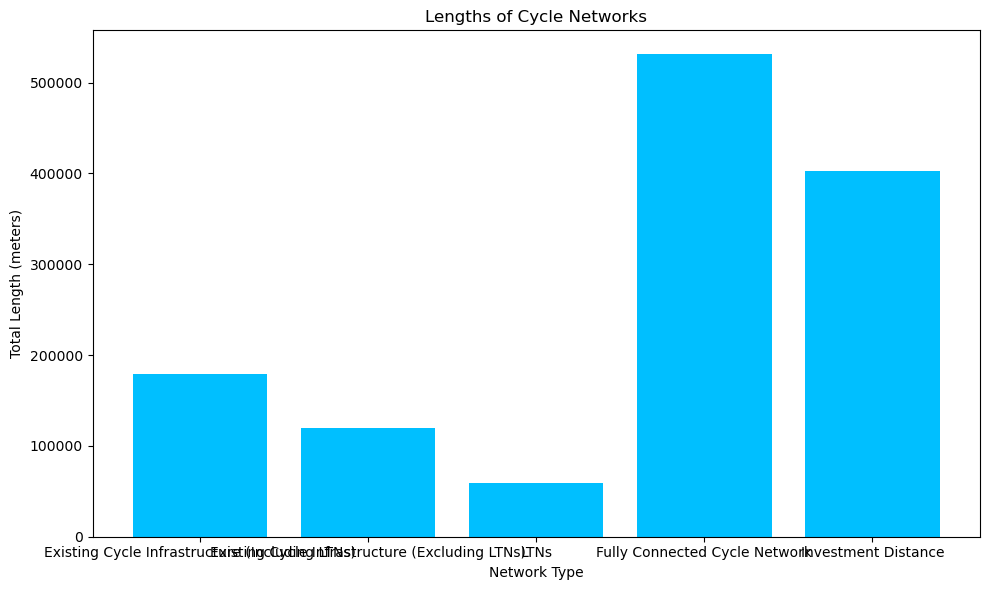

Total length of fully connected network: 531083.761
Total length of G_biketrack: 178662.477
Total length of G_biketrack_no_ltn: 119467.591
Difference in total length: 59194.88600000001


In [170]:
# Load existing results if available
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}

# Calculate values first (for both print and plot)
total_biketrack = sum(nx.get_edge_attributes(G_biketrack, 'length').values())
total_biketrack_no_ltn = sum(nx.get_edge_attributes(G_biketrack_no_ltn, 'length').values())
total_network = sum(nx.get_edge_attributes(GTs[-1], 'length').values())
investment_length = sum(
    data.get('length', 0) * distance_cost.get(data.get('highway', 'unclassified'), 1)
    for _, _, data in GTs[-1].edges(data=True)
)


# Store in analysis results (with both formats)
length_stats = {
    # For plotting
    'length_comparison_labels': [
        "Existing Cycle Infrastructure (Including LTNs)",
        "Existing Cycle Infrastructure (Excluding LTNs)", 
        "LTNs",
        "Fully Connected Cycle Network",
        "Investment Distance"
    ],
    'length_comparison_values': [
        total_biketrack,
        total_biketrack_no_ltn,
        abs(total_biketrack - total_biketrack_no_ltn),
        total_network,
        investment_length
    ],
    'length_comparison_colors': ['deepskyblue', 'deepskyblue', 'deepskyblue'],
    
    # For easy printing access
    'total_network_length': total_network,
    'total_biketrack_length': total_biketrack,
    'total_biketrack_no_ltn_length': total_biketrack_no_ltn,
    'length_difference': abs(total_biketrack - total_biketrack_no_ltn),
    'total_investment_length': investment_length
}

# Non-destructive update
analysis_results.update(length_stats)

# Save updated results
with open(analysis_res_pickle, 'wb') as f:
    pickle.dump(analysis_results, f)

# Update CSV
pd.DataFrame({k: [v] for k,v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(
    analysis_results['length_comparison_labels'], 
    analysis_results['length_comparison_values'],
    color=analysis_results['length_comparison_colors']
)
plt.xlabel('Network Type')
plt.ylabel('Total Length (meters)')
plt.title('Lengths of Cycle Networks')
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/allLengths.png"
plt.savefig(output_path, dpi=300)
plt.show()

# Print statements
print(f"Total length of fully connected network: {length_stats['total_network_length']}")
print(f"Total length of G_biketrack: {length_stats['total_biketrack_length']}")
print(f"Total length of G_biketrack_no_ltn: {length_stats['total_biketrack_no_ltn_length']}")
print(f"Difference in total length: {length_stats['length_difference']}")

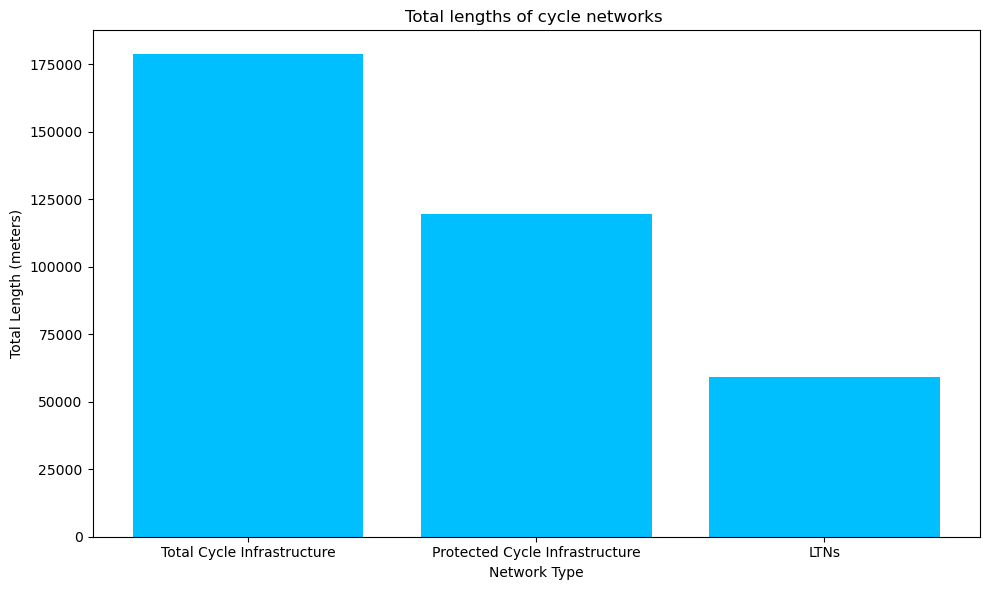

In [171]:
# Calculate the absolute difference
ltn_difference = abs(total_biketrack  - total_biketrack_no_ltn)

# Data for plotting
labels = [
    "Total Cycle Infrastructure",
    "Protected Cycle Infrastructure",
    "LTNs"]
values = [total_biketrack, total_biketrack_no_ltn, ltn_difference]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['deepskyblue', 'deepskyblue', 'deepskyblue'])
plt.xlabel('Network Type')
plt.ylabel('Total Length (meters)')
plt.title('Total lengths of cycle networks ')


plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/TotalLengthsCycleNet.png"
plt.savefig(output_path, dpi=300)
plt.show()

#### Pure length - how is the budget used per iteration

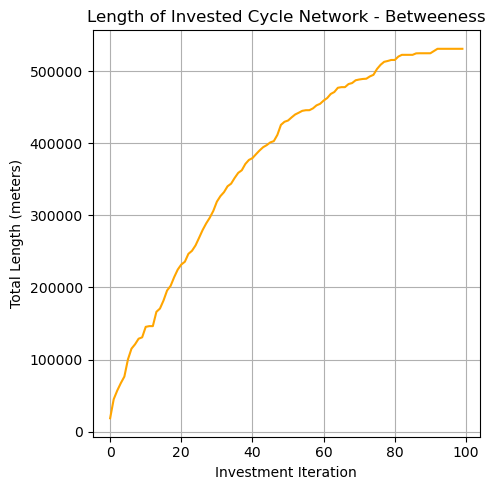

In [172]:
total_lengths = []
for G in GTs:
    # Use nx.get_edge_attributes to retrieve the edge lengths
    lengths = nx.get_edge_attributes(G, 'length')  # Returns a dictionary {edge: length}
    total_length = sum(lengths.values())  # Sum up the lengths
    total_lengths.append(total_length)

# Plot the total lengths
plt.figure(figsize=(5, 5))  # Narrower and taller dimensions
plt.plot(total_lengths, linestyle='-', color='orange')
plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network - Betweeness')
plt.grid(True)
plt.tight_layout()  # Adjust spacing for a clean look
plt.show()

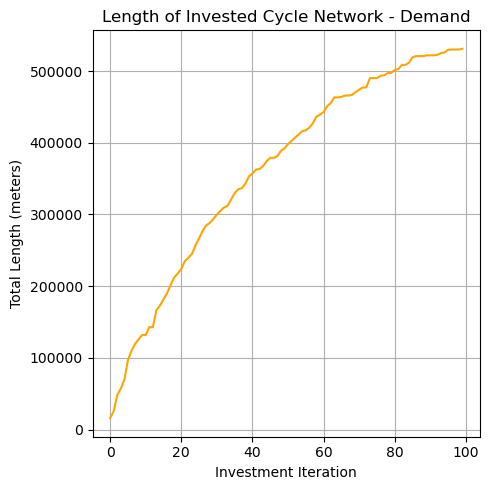

In [173]:
total_lengths = []
for G in GTs_demand:
    # Use nx.get_edge_attributes to retrieve the edge lengths
    lengths = nx.get_edge_attributes(G, 'length')  # Returns a dictionary {edge: length}
    total_length = sum(lengths.values())  # Sum up the lengths
    total_lengths.append(total_length)

# Plot the total lengths
plt.figure(figsize=(5, 5))  # Narrower and taller dimensions
plt.plot(total_lengths, linestyle='-', color='orange')
plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network - Demand')
plt.grid(True)
plt.tight_layout()  # Adjust spacing for a clean look
plt.show()

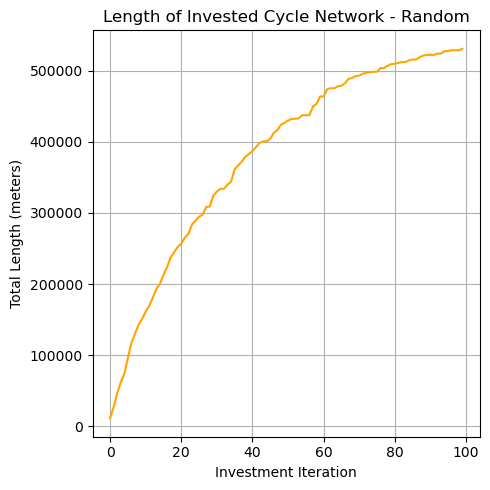

In [174]:
total_lengths = []
for G in GTs_random:
    # Use nx.get_edge_attributes to retrieve the edge lengths
    lengths = nx.get_edge_attributes(G, 'length')  # Returns a dictionary {edge: length}
    total_length = sum(lengths.values())  # Sum up the lengths
    total_lengths.append(total_length)

# Plot the total lengths
plt.figure(figsize=(5, 5))  # Narrower and taller dimensions
plt.plot(total_lengths, linestyle='-', color='orange')
plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network - Random')
plt.grid(True)
plt.tight_layout()  # Adjust spacing for a clean look
plt.show()

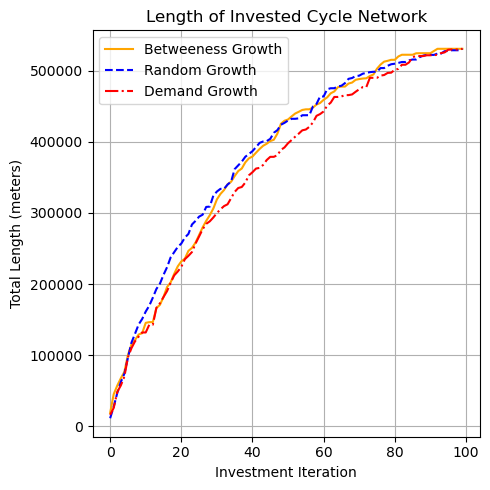

In [175]:
analysis_results = {}
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)


if rerun or 'total_lengths' not in analysis_results:
    # Perform analysis for GTs
    total_lengths = []
    for G in GTs:
        lengths = nx.get_edge_attributes(G, 'length')
        total_lengths.append(sum(lengths.values()))
    
    # Perform analysis for GTs_random
    random_total_lengths = []
    for G in GTs_random:
        lengths = nx.get_edge_attributes(G, 'length')
        random_total_lengths.append(sum(lengths.values()))

    # Perform for demand
    demand_total_lengths = []
    for G in GTs_demand:
        lengths = nx.get_edge_attributes(G, 'length')
        demand_total_lengths.append(sum(lengths.values()))
    
    # Update dictionary
    analysis_results.update({
        'total_lengths': total_lengths,
        'random_total_lengths': random_total_lengths,
        'demand_total_lengths': demand_total_lengths
    })
    
    # Save updated results
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    
    # save to csv
    df = pd.DataFrame({k: pd.Series(v) for k,v in analysis_results.items()})
    df.to_csv(analysis_res_csv, index=False)

# Plot the analysis results
plt.figure(figsize=(5, 5))
plt.plot(analysis_results['total_lengths'], linestyle='-', color='orange', label='Betweeness Growth')
plt.plot(analysis_results['random_total_lengths'], linestyle='--', color='blue', label='Random Growth')
plt.plot(analysis_results['demand_total_lengths'], linestyle='-.', color='red', label='Demand Growth')
plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network')
plt.legend()
plt.grid(True)
plt.tight_layout()

output_path = PATH["plots"] + "/" + placeid + "/loInvestment.png"
plt.savefig(output_path, dpi=300)

plt.show()





#### "Actual" investment length - how much do we actually need to use to close gaps

Calculate length, minus the existing infrastructure

In [176]:
# for G in GTs:
#     for u, v, data in G.edges(data=True):
#         highway_type = data.get('highway', 'unclassified') # Default to unclassified if no highway attribute
#         length = data.get('length', 0) # Default to 0 if no length attribute
#         investment_length = length * distance_cost.get(highway_type, 1) 
#         data['investment_length'] = investment_length # make a new edge attribute called investment_length

# if GTs_random:
#     for G in GTs_random:
#         for u, v, data in G.edges(data=True):
#             highway_type = data.get('highway', 'unclassified')
#             length = data.get('length', 0)
#             investment_length = length * distance_cost.get(highway_type, 1)
#             data['investment_length'] = investment_length



#### Find how much we actually need to invest

In [177]:

# total_investment_lengths = []
# for G in GTs:
#     lengths = nx.get_edge_attributes(G, 'investment_length')
#     total_investment_length = sum(lengths.values())
#     total_investment_lengths.append(total_investment_length)

# plt.figure(figsize=(5, 5))
# plt.plot(total_investment_lengths, linestyle='-', color='orange', label='Betweeness Growth')

# # Plot the total lengths for Random_GTs
# random_total_investment_lengths = []
# for G in GTs_random:
#     lengths = nx.get_edge_attributes(G, 'investment_length')
#     total_investment_length = sum(lengths.values())
#     random_total_investment_lengths.append(total_investment_length)

# plt.plot(random_total_lengths, linestyle='--', color='blue', label='Random Growth')

# plt.xlabel('Investment Iteration')
# plt.ylabel('Total Length (meters)')
# plt.title('Length of Investment needed')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

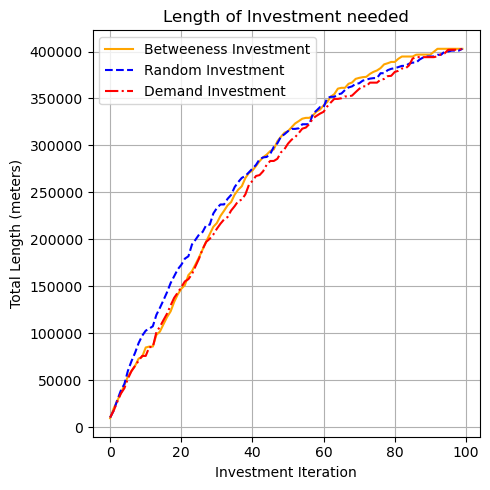

In [178]:
analysis_results = {}
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)


if rerun or 'total_investment_lengths' not in analysis_results:

    for G in GTs:
        for u, v, data in G.edges(data=True):
            highway_type = data.get('highway', 'unclassified')
            length = data.get('length', 0)
            data['investment_length'] = length * distance_cost.get(highway_type, 1)

    if GTs_random:
        for G in GTs_random:
            for u, v, data in G.edges(data=True):
                highway_type = data.get('highway', 'unclassified')
                length = data.get('length', 0)
                data['investment_length'] = length * distance_cost.get(highway_type, 1)

    if GTs_demand:
        for G in GTs_demand:
            for u, v, data in G.edges(data=True):
                highway_type = data.get('highway', 'unclassified')
                length = data.get('length', 0)
                data['investment_length'] = length * distance_cost.get(highway_type, 1)
    
    # Calculate totals
    investment_totals        = [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs]
    random_investment_totals = [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs_random]
    demand_investment_totals = [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs_demand]

    analysis_results.update({
        'total_investment_lengths':        investment_totals,
        'random_total_investment_lengths': random_investment_totals,
        'demand_total_investment_lengths': demand_investment_totals,
    })
    
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    
    df = pd.DataFrame({k: pd.Series(v) for k,v in analysis_results.items()})
    df.to_csv(analysis_res_csv, index=False)

plt.figure(figsize=(5, 5))
plt.plot(analysis_results['total_investment_lengths'],        '-',  color='orange', label='Betweeness Investment')
plt.plot(analysis_results['random_total_investment_lengths'], '--', color='blue',   label='Random Investment')
plt.plot(analysis_results['demand_total_investment_lengths'], '-.', color='red',    label='Demand Investment')
plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Investment needed')
plt.legend()
plt.grid(True)
plt.tight_layout()

output_path = PATH["plots"] + "/" + placeid + "/RequiredloInvestment.png"
plt.savefig(output_path, dpi=300)

plt.show()


Find comparison between how much we need against full route lengths

In [179]:
# # Compute total lengths using 'investment_length'
# investment_total_lengths = [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs]
# random_investment_total_lengths = [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs_random]

# # Compute total lengths using 'length'
# length_total_lengths = [sum(nx.get_edge_attributes(G, 'length').values()) for G in GTs]
# random_length_total_lengths = [sum(nx.get_edge_attributes(G, 'length').values()) for G in GTs_random]

# # Plot both sets of lines
# plt.figure(figsize=(6, 6))

# # Original lines
# plt.plot(investment_total_lengths, linestyle='-', color='orange', label='Betweenness Growth (Investment Length)')
# plt.plot(random_investment_total_lengths, linestyle='--', color='blue', label='Random Growth (Investment Length)')

# # Darker lines for 'length' attribute
# plt.plot(length_total_lengths, linestyle='-', color='darkorange', alpha=0.7, label='Betweenness Growth (Total Length)')
# plt.plot(random_length_total_lengths, linestyle='--', color='darkblue', alpha=0.7, label='Random Growth (Total Length)')

# plt.xlabel('Investment Iteration')
# plt.ylabel('Total Length (meters)')
# plt.title('Network size vs investment required comparison')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


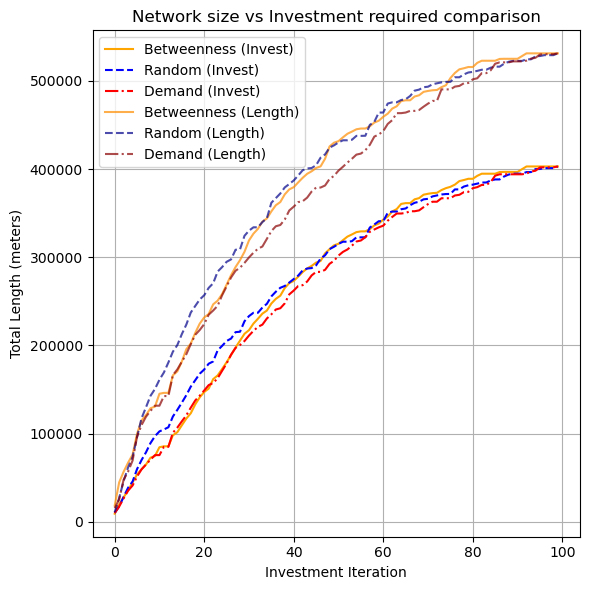

In [180]:
analysis_results = {}
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)

if rerun or 'length_total_lengths' not in analysis_results:
    if rerun or 'total_investment_lengths' not in analysis_results:
    
        for G in GTs:
            for u, v, data in G.edges(data=True):
                hwy = data.get('highway', 'unclassified')
                data['investment_length'] = data.get('length', 0) * distance_cost.get(hwy, 1)
     
        if GTs_random:
            for G in GTs_random:
                for u, v, data in G.edges(data=True):
                    hwy = data.get('highway', 'unclassified')
                    data['investment_length'] = data.get('length', 0) * distance_cost.get(hwy, 1)
   
        if GTs_demand:
            for G in GTs_demand:
                for u, v, data in G.edges(data=True):
                    hwy = data.get('highway', 'unclassified')
                    data['investment_length'] = data.get('length', 0) * distance_cost.get(hwy, 1)


    metrics = {
        'investment_total_lengths':        [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs],
        'random_investment_total_lengths': [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs_random],
        'demand_investment_total_lengths': [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs_demand],
        'length_total_lengths':            [sum(nx.get_edge_attributes(G, 'length').values())            for G in GTs],
        'random_length_total_lengths':     [sum(nx.get_edge_attributes(G, 'length').values())            for G in GTs_random],
        'demand_length_total_lengths':     [sum(nx.get_edge_attributes(G, 'length').values())            for G in GTs_demand],
    }

    analysis_results.update(metrics)
    
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    df = pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()})
    df.to_csv(analysis_res_csv, index=False)

# Plot comparison
plt.figure(figsize=(6, 6))
plt.plot(analysis_results['investment_total_lengths'],        '-',  color='orange',    label='Betweenness (Invest)')
plt.plot(analysis_results['random_investment_total_lengths'], '--', color='blue',     label='Random (Invest)')
plt.plot(analysis_results['demand_investment_total_lengths'], '-.', color='red',      label='Demand (Invest)')
plt.plot(analysis_results['length_total_lengths'],            '-',  color='darkorange', alpha=0.7, label='Betweenness (Length)')
plt.plot(analysis_results['random_length_total_lengths'],     '--', color='darkblue',   alpha=0.7, label='Random (Length)')
plt.plot(analysis_results['demand_length_total_lengths'],     '-.', color='darkred',    alpha=0.7, label='Demand (Length)')

plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Network size vs Investment required comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()

output_path = PATH["plots"] + f"/{placeid}/Required_vs_networksize_loInvestment.png"
plt.savefig(output_path, dpi=300)
plt.show()


Find differance between network size and required investment

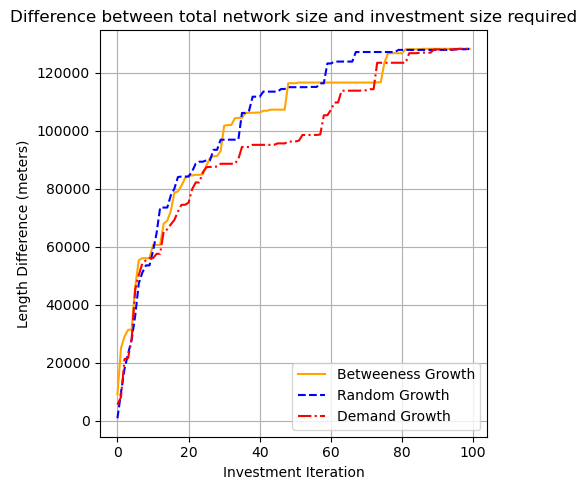

In [181]:
# length_differences = []
# for G in GTs:
#     lengths = nx.get_edge_attributes(G, 'length')
#     investment_lengths = nx.get_edge_attributes(G, 'investment_length')
#     total_length = sum(lengths.values())
#     total_investment_length = sum(investment_lengths.values())
#     length_difference = total_length - total_investment_length
#     length_differences.append(length_difference)

# random_length_differences = []
# for G in GTs_random:
#     random_lengths = nx.get_edge_attributes(G, 'length')
#     random_investment_lengths = nx.get_edge_attributes(G, 'investment_length')
#     random_total_length = sum(random_lengths.values())
#     random_total_investment_length = sum(random_investment_lengths.values())
#     random_length_difference = random_total_length - random_total_investment_length
#     random_length_differences.append(random_length_difference)




# # Plot the length differences
# plt.figure(figsize=(5, 5))
# plt.plot(length_differences, linestyle='-', color='green', label='Betweenness Growth')
# plt.plot(random_length_differences, linestyle='--', color='blue', label='Random Growth')
# plt.xlabel('Investment Iteration')
# plt.ylabel('Length Difference (meters)')
# plt.title('Length Difference between total network size and investment size required')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()
analysis_results = {}
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)


if rerun or 'length_differences' not in analysis_results:
    # Calculate differences
    length_diffs = {
        'length_differences': [
            sum(nx.get_edge_attributes(G, 'length').values()) -
            sum(nx.get_edge_attributes(G, 'investment_length').values())
            for G in GTs
        ],
        'random_length_differences': [
            sum(nx.get_edge_attributes(G, 'length').values()) -
            sum(nx.get_edge_attributes(G, 'investment_length').values())
            for G in GTs_random
        ],
        'demand_length_differences': [
            sum(nx.get_edge_attributes(G, 'length').values()) -
            sum(nx.get_edge_attributes(G, 'investment_length').values())
            for G in GTs_demand
        ]
    }

    analysis_results.update(length_diffs)

    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    df = pd.DataFrame({k: pd.Series(v) for k,v in analysis_results.items()})
    df.to_csv(analysis_res_csv, index=False)

# Plot length differences
plt.figure(figsize=(5, 5))
plt.plot(analysis_results['length_differences'],         '-',  color='orange', label='Betweeness Growth')
plt.plot(analysis_results['random_length_differences'],  '--', color='blue',  label='Random Growth')
plt.plot(analysis_results['demand_length_differences'],  '-.', color='red',   label='Demand Growth')  # demand line
plt.xlabel('Investment Iteration')
plt.ylabel('Length Difference (meters)')
plt.title('Difference between total network size and investment size required')
plt.legend()
plt.grid(True)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/loInvestment_diff.png"
plt.savefig(output_path, dpi=300)

plt.show()



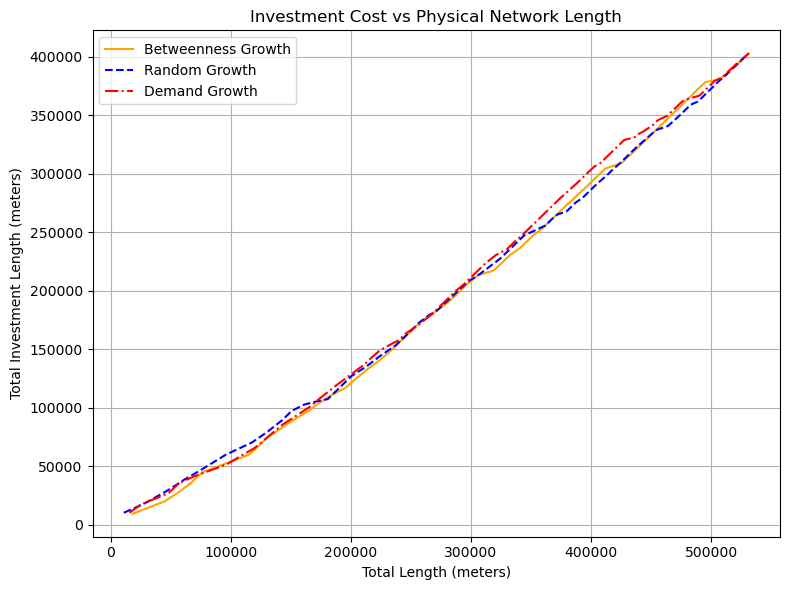

In [182]:
# lengths_list = []
# investment_lengths_list = []

# random_lengths_list = []
# random_investment_lengths_list = []

# # Process GTs
# for G in GTs:
#     lengths = nx.get_edge_attributes(G, 'length')
#     investment_lengths = nx.get_edge_attributes(G, 'investment_length')
    
#     total_length = sum(lengths.values())
#     total_investment_length = sum(investment_lengths.values())
    
#     lengths_list.append(total_length)
#     investment_lengths_list.append(total_investment_length)

# # Process GTs_random
# for G in GTs_random:
#     lengths = nx.get_edge_attributes(G, 'length')
#     investment_lengths = nx.get_edge_attributes(G, 'investment_length')
    
#     total_length = sum(lengths.values())
#     total_investment_length = sum(investment_lengths.values())
    
#     random_lengths_list.append(total_length)
#     random_investment_lengths_list.append(total_investment_length)

# # Plot the lengths against investment lengths
# plt.figure(figsize=(8, 6))
# plt.plot(lengths_list, investment_lengths_list, '-', color='purple', label='Betweenness Growth')
# plt.plot(random_lengths_list, random_investment_lengths_list, '--', color='blue', label='Random Growth')
# plt.xlabel('Total Length (meters)')
# plt.ylabel('Total Investment Length (meters)')
# plt.title('Investment Length vs. Length for GTs and GTs_random')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

analysis_results = {}
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)

if rerun or 'lengths_vs_investment' not in analysis_results:
    metrics = {
        'lengths_list':                   [sum(nx.get_edge_attributes(G, 'length').values())             for G in GTs],
        'investment_lengths_list':        [sum(nx.get_edge_attributes(G, 'investment_length').values())  for G in GTs],
        'random_lengths_list':            [sum(nx.get_edge_attributes(G, 'length').values())             for G in GTs_random],
        'random_investment_lengths_list': [sum(nx.get_edge_attributes(G, 'investment_length').values())  for G in GTs_random],
        'demand_lengths_list':            [sum(nx.get_edge_attributes(G, 'length').values())             for G in GTs_demand],
        'demand_investment_lengths_list': [sum(nx.get_edge_attributes(G, 'investment_length').values())  for G in GTs_demand],
    }

    analysis_results.update(metrics)
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    df = pd.DataFrame({k: pd.Series(v) for k,v in analysis_results.items()})
    df.to_csv(analysis_res_csv, index=False)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(
    analysis_results['lengths_list'], 
    analysis_results['investment_lengths_list'], 
    '-', color='orange', label='Betweenness Growth'
)
plt.plot(
    analysis_results['random_lengths_list'], 
    analysis_results['random_investment_lengths_list'], 
    '--', color='blue', label='Random Growth'
)
plt.plot(
    analysis_results['demand_lengths_list'], 
    analysis_results['demand_investment_lengths_list'], 
    '-.', color='red', label='Demand Growth'
)
plt.xlabel('Total Length (meters)')
plt.ylabel('Total Investment Length (meters)')
plt.title('Investment Cost vs Physical Network Length')
plt.legend()
plt.grid(True)
plt.tight_layout()
output_path = PATH["plots"] + f"/{placeid}/loInvestmentcost_vs_length.png"
plt.savefig(output_path, dpi=300)

plt.show()


### Distance gained

Here we are trying to find how much of the existing network is connected per iteration. 

total bike network - G_bikeall

G'investment_length' - investment size

G'length' - length of created network, not including netowrk size

need to do a compose of G_bikeall and G in GTs

but only compose where infrastucutre is connected to our generated network 

Find the length of infrastructure connected to generated network, along with the combined length. Thus we now know how much extra cycle network is connected per level of investment.

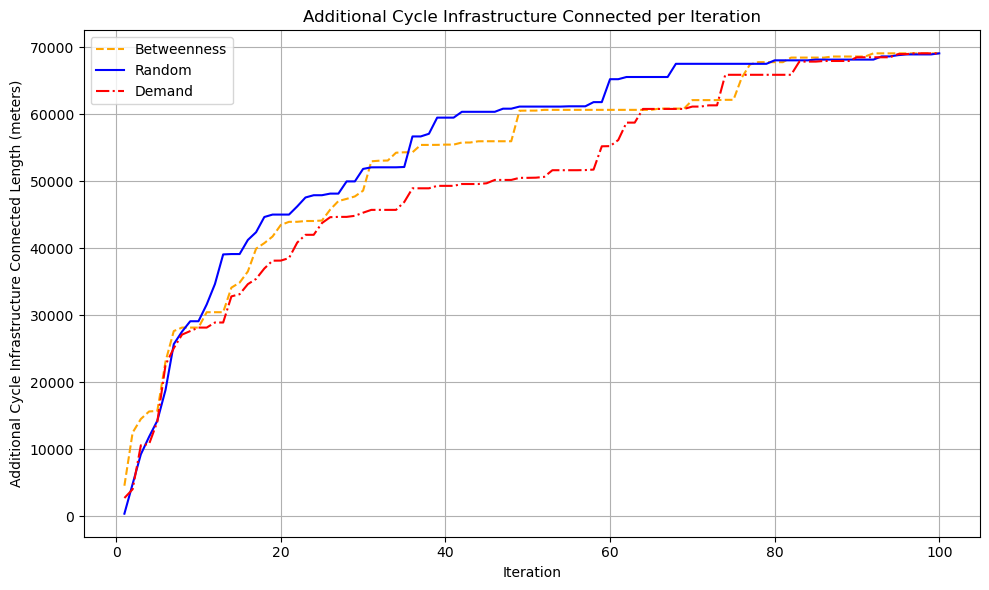

In [183]:
# def total_length(G):
#     """Computes total edge length in a graph."""
#     return sum(data.get('length', 1) for _, _, data in G.edges(data=True))

# def compute_lengths(graph_list, G_biketrack):
#     """Computes total, connected, and combined lengths for a list of graphs."""
#     G_lengths = []
#     biketrack_lengths = []
#     combined_lengths = []

#     for G in graph_list:
#         length_G = total_length(G)

#         # Find overlapping nodes
#         common_nodes = set(G.nodes) & set(G_biketrack.nodes)

#         # Extract the connected subgraph of G_biketrack
#         G_biketrack_subgraph = G_biketrack.subgraph(common_nodes)
#         length_G_biketrack_connected = total_length(G_biketrack_subgraph)

#         # Compute final combined length
#         total_combined_length = length_G + length_G_biketrack_connected

#         # Store values for plotting
#         G_lengths.append(length_G)
#         biketrack_lengths.append(length_G_biketrack_connected)
#         combined_lengths.append(total_combined_length)

#     return G_lengths, biketrack_lengths, combined_lengths

# # Compute lengths for both GTs and GTs_random
# G_lengths, biketrack_lengths, combined_lengths = compute_lengths(GTs, G_biketrack)
# G_random_lengths, biketrack_random_lengths, combined_random_lengths = compute_lengths(GTs_random, G_biketrack)

# # Plot the results
# plt.figure(figsize=(10, 6))

# # Plot GTs
# #plt.plot(range(1, len(GTs) + 1), G_lengths, marker='o', linestyle='-', color='blue', label="G (GTs)")
# plt.plot(range(1, len(GTs) + 1), biketrack_lengths,  linestyle='-', color='green', label="Betweeness")
# #plt.plot(range(1, len(GTs) + 1), combined_lengths, marker='^', linestyle='-', color='purple', label="Combined Total (GTs)")

# # Plot GTs_random
# #plt.plot(range(1, len(GTs_random) + 1), G_random_lengths, marker='o', linestyle='--', color='red', label="G (GTs_random)")
# plt.plot(range(1, len(GTs_random) + 1), biketrack_random_lengths,  linestyle='--', color='orange', label="Random)")
# #plt.plot(range(1, len(GTs_random) + 1), combined_random_lengths, marker='^', linestyle='--', color='brown', label="Combined Total (GTs_random)")

# # Labels and title
# plt.xlabel("Iteration")
# plt.ylabel("Addtional Cycle Infrastucture Connected Length (meters)")
# plt.title("Graph Length Comparisons (GTs vs. GTs_random)")
# plt.legend()
# plt.grid(True)

# # Show the plot
# plt.show()
analysis_results = {}
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)

if rerun or 'biketrack_lengths' not in analysis_results:
    def total_length(G):
        return sum(data.get('length', 1) for _, _, data in G.edges(data=True))  
    
    def compute_lengths(graph_list, G_biketrack):
        G_lengths = []
        biketrack_lengths = []
        combined_lengths = []
        
        for G in graph_list:
            length_G = total_length(G)
            common_nodes = set(G.nodes) & set(G_biketrack.nodes)
            G_biketrack_subgraph = G_biketrack.subgraph(common_nodes)
            length_G_biketrack_connected = total_length(G_biketrack_subgraph)
            
            G_lengths.append(length_G)
            biketrack_lengths.append(length_G_biketrack_connected)
            combined_lengths.append(length_G + length_G_biketrack_connected)
        
        return G_lengths, biketrack_lengths, combined_lengths

    # Betweenness
    (analysis_results['GT_lengths'], 
     analysis_results['biketrack_lengths'], 
     analysis_results['combined_lengths']) = compute_lengths(GTs, G_biketrack)
    
    # Random
    (analysis_results['GT_random_lengths'], 
     analysis_results['biketrack_random_lengths'], 
     analysis_results['combined_random_lengths']) = compute_lengths(GTs_random, G_biketrack)
    
 
    (analysis_results['GT_demand_lengths'],
     analysis_results['biketrack_demand_lengths'],
     analysis_results['combined_demand_lengths']) = compute_lengths(GTs_demand, G_biketrack)

    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    df = pd.DataFrame({k: pd.Series(v) for k,v in analysis_results.items()})
    df.to_csv(analysis_res_csv, index=False)

# Plot just the bike track connected lengths 
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(analysis_results['biketrack_lengths']) + 1),
    analysis_results['biketrack_lengths'],
    '--', color='orange', label="Betweenness"
)
plt.plot(
    range(1, len(analysis_results['biketrack_random_lengths']) + 1),
    analysis_results['biketrack_random_lengths'],
    '-', color='blue', label="Random"
)

plt.plot(
    range(1, len(analysis_results['biketrack_demand_lengths']) + 1),
    analysis_results['biketrack_demand_lengths'],
    '-.', color='red', label="Demand"
)

plt.xlabel("Iteration")
plt.ylabel("Additional Cycle Infrastructure Connected Length (meters)")
plt.title("Additional Cycle Infrastructure Connected per Iteration")
plt.legend()
plt.grid(True)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/additional_cyclenet_connected.png"
plt.savefig(output_path, dpi=300)


plt.show()


### Connected Components 

Find the length of the largest connected component, first a just our investment, then combined with existing network, then by combined but only where its connected

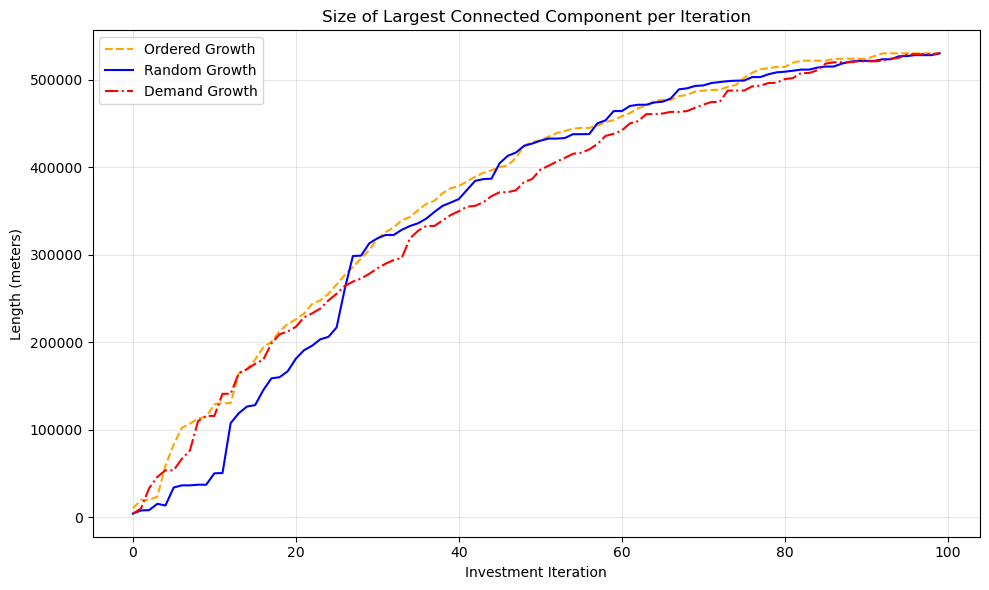

In [184]:
# # just grown networks

# # Compute the largest connected component lengths for each graph in GTs
# lcc_lengths_GTs = []
# for G in GTs:
#     largest_cc = max(nx.weakly_connected_components(G), key=len)
#     subgraph = G.subgraph(largest_cc)
#     length_lcc = sum(data['length'] for u, v, data in subgraph.edges(data=True))
#     lcc_lengths_GTs.append(length_lcc)

# # Compute the largest connected component lengths for each graph in GTs_random
# lcc_lengths_GTs_random = []
# for G in GTs_random:
#     largest_cc = max(nx.weakly_connected_components(G), key=len)
#     subgraph = G.subgraph(largest_cc)
#     length_lcc = sum(data['length'] for u, v, data in subgraph.edges(data=True))
#     lcc_lengths_GTs_random.append(length_lcc)

# # Create the plot
# plt.figure(figsize=(10, 6))
# plt.plot(lcc_lengths_GTs, linestyle='-', color='blue', label='GTs - Largest Connected Component')
# plt.plot(lcc_lengths_GTs_random, linestyle='--', color='orange', label='GTs_random - Largest Connected Component')
# plt.xlabel('Graph Index')
# plt.ylabel('Length (meters)')
# plt.title('Length of Largest Connected Component per Iteration')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}

if rerun or 'lcc_lengths_GTs' not in analysis_results:
    # Compute LCC lengths
    lcc_data = {
        'lcc_lengths_GTs': [
            sum(data['length'] for _, _, data in 
                G.subgraph(max(nx.weakly_connected_components(G), key=len)).edges(data=True))
            for G in GTs
        ],
        'lcc_lengths_GTs_random': [
            sum(data['length'] for _, _, data in 
                G.subgraph(max(nx.weakly_connected_components(G), key=len)).edges(data=True))
            for G in GTs_random
        ],
        'lcc_lengths_GTs_demand': [
            sum(data['length'] for _, _, data in 
                G.subgraph(max(nx.weakly_connected_components(G), key=len)).edges(data=True))
            for G in GTs_demand
        ]
    }

    analysis_results.update(lcc_data)

    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    pd.DataFrame({k: pd.Series(v) for k,v in analysis_results.items()}) \
      .to_csv(analysis_res_csv, index=False)

# Plot LCC lengths
plt.figure(figsize=(10, 6))
plt.plot(
    analysis_results['lcc_lengths_GTs'], 
    '--', color='orange', label='Ordered Growth'
)
plt.plot(
    analysis_results['lcc_lengths_GTs_random'], 
    '-', color='blue', label='Random Growth'
)

plt.plot(
    analysis_results['lcc_lengths_GTs_demand'],
    '-.', color='red', label='Demand Growth'
)
plt.xlabel('Investment Iteration')
plt.ylabel('Length (meters)')
plt.title('Size of Largest Connected Component per Iteration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/size_of_lcc.png"
plt.savefig(output_path, dpi=300)


plt.show()


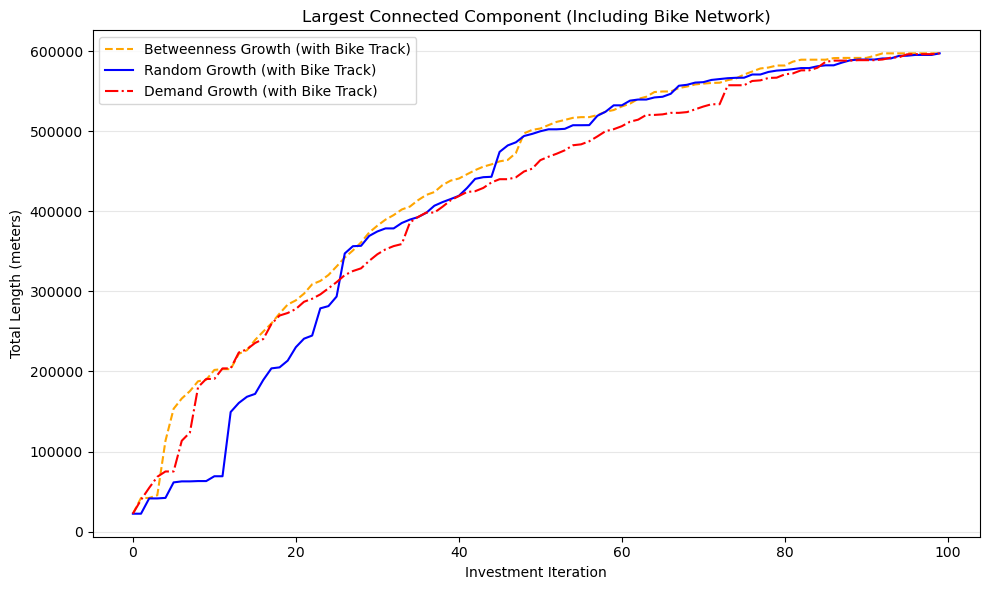

In [185]:
# def compute_lcc_lengths(graph_list, G_biketrack):
#     """Computes the total length of the largest connected component for each graph in the list."""
#     total_lengths_lcc = []
    
#     for G in graph_list:
#         # Compose graphs and find largest connected component
#         merged = nx.compose(G, G_biketrack)
        
#         # Get weakly connected components (works for both directed/undirected graphs)
#         components = list(nx.weakly_connected_components(merged))
        
#         if not components:
#             total_length = 0.0  # Handle empty graph case
#         else:
#             # Find largest component by node count
#             largest_component_nodes = max(components, key=len)
#             largest_component = merged.subgraph(largest_component_nodes)
            
#             # Calculate total edge length in the largest component
#             total_length = sum(data['length'] for u, v, data in largest_component.edges(data=True))
        
#         total_lengths_lcc.append(total_length)
    
#     return total_lengths_lcc

# # Compute LCC lengths for GTs and GTs_random
# total_lengths_lcc_GTs = compute_lcc_lengths(GTs, G_biketrack)
# total_lengths_lcc_GTs_random = compute_lcc_lengths(GTs_random, G_biketrack)

# # Create the plot
# plt.figure(figsize=(10, 6))

# # Plot GTs
# plt.plot(
#     range(len(total_lengths_lcc_GTs)), total_lengths_lcc_GTs, linestyle='-', color='blue', label="GTs"
# )

# # Plot GTs_random
# plt.plot(
#     range(len(total_lengths_lcc_GTs_random)), total_lengths_lcc_GTs_random, linestyle='--', color='orange', label="GTs_random"
# )

# # Labels and title
# plt.title('Total Length of Largest Connected Component')
# plt.xlabel('Graph Index')
# plt.ylabel('Total Length (meters)')
# plt.grid(True, axis='y', alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()

if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}

if rerun or 'composite_lcc_GTs' not in analysis_results:
    def compute_lcc_lengths(graph_list, G_biketrack):
        total_lengths_lcc = []
        for G in graph_list:
            merged = nx.compose(G, G_biketrack)
            components = list(nx.weakly_connected_components(merged))
            
            if not components:
                total_length = 0.0
            else:
                largest_component = merged.subgraph(max(components, key=len))
                total_length = sum(data.get('length', 0) for _, _, data in largest_component.edges(data=True))
            
            total_lengths_lcc.append(total_length)
        return total_lengths_lcc

    composite_data = {
        'composite_lcc_GTs': compute_lcc_lengths(GTs, G_biketrack),
        'composite_lcc_GTs_random': compute_lcc_lengths(GTs_random, G_biketrack),
        'composite_lcc_GTs_demand': compute_lcc_lengths(GTs_demand, G_biketrack),
    }

    analysis_results.update(composite_data)
    
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    df = pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()})
    df.to_csv(analysis_res_csv, index=False)

# Plot composite LCC results
plt.figure(figsize=(10, 6))
plt.plot(
    analysis_results['composite_lcc_GTs'],
    '--', color='orange',
    label='Betweenness Growth (with Bike Track)'
)
plt.plot(
    analysis_results['composite_lcc_GTs_random'],
    '-', color='blue',
    label='Random Growth (with Bike Track)'
)
plt.plot(
    analysis_results['composite_lcc_GTs_demand'],
    '-.', color='red',
    label='Demand Growth (with Bike Track)'
)

plt.title('Largest Connected Component (Including Bike Network)')
plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.grid(True, axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/lengthof_lcc_inc_cyclenet.png"
plt.savefig(output_path, dpi=300)


plt.show()


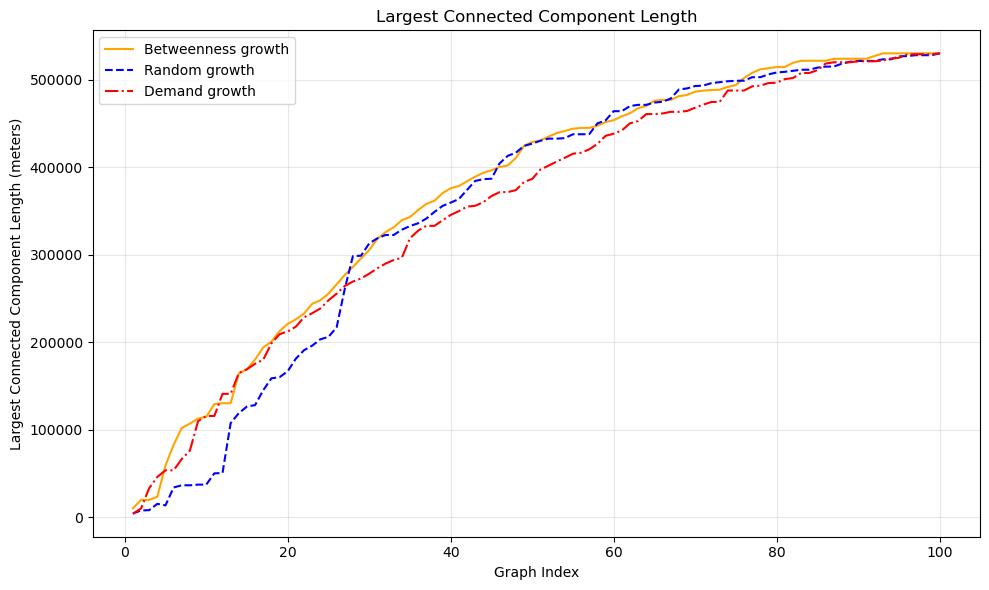

In [186]:


# def total_length(G):
#     """Computes total edge length in a graph."""
#     return sum(data.get('length', 1) for _, _, data in G.edges(data=True))

# def compute_lcc_lengths(graph_list, G_biketrack):
#     """Computes the total length of the largest connected component for each graph in the list."""
#     lcc_lengths = []

#     for G in graph_list:
#         # Find the common nodes between G and G_biketrack
#         common_nodes = set(G.nodes) & set(G_biketrack.nodes)

#         # If there are no common nodes, we can't compose, so we skip and set LCC length to 0
#         if not common_nodes:
#             lcc_lengths.append(0.0)
#             continue
        
#         # Create a subgraph of G_biketrack with only the common nodes
#         G_biketrack_subgraph = G_biketrack.subgraph(common_nodes)

#         # Merge G with the G_biketrack subgraph
#         merged = nx.compose(G, G_biketrack_subgraph)

#         # Find weakly connected components (works for both directed/undirected graphs)
#         components = list(nx.weakly_connected_components(merged))

#         if not components:
#             total_length_lcc = 0.0  # Handle empty graph case
#         else:
#             # Find the largest connected component by node count
#             largest_component_nodes = max(components, key=len)
#             largest_component = merged.subgraph(largest_component_nodes)

#             # Calculate total edge length in the largest component
#             total_length_lcc = sum(data.get('length', 1) for u, v, data in largest_component.edges(data=True))

#         lcc_lengths.append(total_length_lcc)

#     return lcc_lengths

# # Compute LCC lengths for both GTs and GTs_random
# lcc_lengths_GTs = compute_lcc_lengths(GTs, G_biketrack)
# lcc_lengths_GTs_random = compute_lcc_lengths(GTs_random, G_biketrack)

# # Create the plot
# plt.figure(figsize=(10, 6))

# # Plot LCC lengths for GTs
# plt.plot(range(1, len(lcc_lengths_GTs) + 1), lcc_lengths_GTs, linestyle='-', color='blue', label="GTs - LCC Length")

# # Plot LCC lengths for GTs_random
# plt.plot(range(1, len(lcc_lengths_GTs_random) + 1), lcc_lengths_GTs_random, linestyle='--', color='orange', label="GTs_random - LCC Length")

# # Labels and title
# plt.xlabel("Graph Index")
# plt.ylabel("Largest Connected Component Length (meters)")
# plt.title("Largest Connected Component Length (GTs vs. GTs_random)")
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Show the plot
# plt.tight_layout()
# plt.show()


if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}

if rerun or 'lcc_lengths_GTs' not in analysis_results:

    def total_length(G):
        return sum(data.get('length', 1) for _, _, data in G.edges(data=True))  

    def compute_lcc_lengths(graph_list, G_biketrack):
        lcc_lengths = []
        for G in graph_list:
            common_nodes = set(G.nodes) & set(G_biketrack.nodes)
            if not common_nodes:
                lcc_lengths.append(0.0)
                continue

            G_biketrack_subgraph = G_biketrack.subgraph(common_nodes)
            merged = nx.compose(G, G_biketrack_subgraph)
            components = list(nx.weakly_connected_components(merged))

            if not components:
                total_length_lcc = 0.0
            else:
                largest_nodes = max(components, key=len)
                largest_comp = merged.subgraph(largest_nodes)
                total_length_lcc = sum(
                    data.get('length', 1) for _, _, data in largest_comp.edges(data=True)
                )

            lcc_lengths.append(total_length_lcc)
        return lcc_lengths

    lcc_data = {
        'lcc_lengths_GTs':        compute_lcc_lengths(GTs, G_biketrack),
        'lcc_lengths_GTs_random': compute_lcc_lengths(GTs_random, G_biketrack),
        'lcc_lengths_GTs_demand': compute_lcc_lengths(GTs_demand, G_biketrack),
    }

    analysis_results.update(lcc_data)

    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    df = pd.DataFrame({k: pd.Series(v) for k,v in analysis_results.items()})
    df.to_csv(analysis_res_csv, index=False)

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(analysis_results['lcc_lengths_GTs']) + 1), 
    analysis_results['lcc_lengths_GTs'], 
    linestyle='-', color='orange',  
    label="Betweenness growth"
)
plt.plot(
    range(1, len(analysis_results['lcc_lengths_GTs_random']) + 1), 
    analysis_results['lcc_lengths_GTs_random'], 
    linestyle='--', color='blue', 
    label="Random growth"
)
plt.plot(
    range(1, len(analysis_results['lcc_lengths_GTs_demand']) + 1), 
    analysis_results['lcc_lengths_GTs_demand'], 
    linestyle='-.', color='red', 
    label="Demand growth"
)
plt.xlabel("Graph Index")
plt.ylabel("Largest Connected Component Length (meters)")
plt.title("Largest Connected Component Length")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/lcc_length.png"
plt.savefig(output_path, dpi=300)

plt.show()


### Coverage

Prior to running any coverage analysis, we create buffers of each graph to avoid re-calculating

In [187]:
if rerun == True or 'GTs_buffers' not in locals():
    GTs_buffers = []
    for G in GTs:
        gdf_edges = ox.graph_to_gdfs(G, nodes=False).to_crs(epsg=3857)
        buffer_gdf = gdf_edges.geometry.buffer(buffer_walk).unary_union
        buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_gdf], crs=gdf_edges.crs)
        buffer_gdf = buffer_gdf.to_crs(epsg=4326)
        GTs_buffers.append(buffer_gdf)
    with open(PATH["results"] + placeid + "/" + placeid + "_GTs_buffers.pickle", "wb") as f:
        pickle.dump(GTs_buffers, f)

    GTs_buffers_random = []
    for G in GTs_random:
        gdf_edges = ox.graph_to_gdfs(G, nodes=False).to_crs(epsg=3857)
        buffer_gdf = gdf_edges.geometry.buffer(buffer_walk).unary_union
        buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_gdf], crs=gdf_edges.crs)
        buffer_gdf = buffer_gdf.to_crs(epsg=4326)
        GTs_buffers_random.append(buffer_gdf)
    with open(PATH["results"] + placeid + "/" + placeid + "_GTs_buffers_random.pickle", "wb") as f:
        pickle.dump(GTs_buffers_random, f)

    GTs_buffers_demand = []
    for G in GTs_demand:
        gdf_edges = ox.graph_to_gdfs(G, nodes=False).to_crs(epsg=3857)
        buffer_gdf = gdf_edges.geometry.buffer(buffer_walk).unary_union
        buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_gdf], crs=gdf_edges.crs)
        buffer_gdf = buffer_gdf.to_crs(epsg=4326)
        GTs_buffers_demand.append(buffer_gdf)
    with open(PATH["results"] + placeid + "/" + placeid + "_GTs_buffers_demand.pickle", "wb") as f:
        pickle.dump(GTs_buffers_demand, f)

else:
    try:
        with open(PATH["results"] + placeid + "/" + placeid + "_GTs_buffers.pickle", "rb") as f:
            GTs_buffers = pickle.load(f)
        with open(PATH["results"] + placeid + "/" + placeid + "_GTs_buffers_random.pickle", "rb") as f:
            GTs_buffers_random = pickle.load(f)
        with open(PATH["results"] + placeid + "/" + placeid + "_GTs_buffers_demand.pickle", "rb") as f:
            GTs_buffers_demand = pickle.load(f)
    except FileNotFoundError:
        print("Buffer files not found. Please set rerun to True to regenerate them.")


#### Area coverage

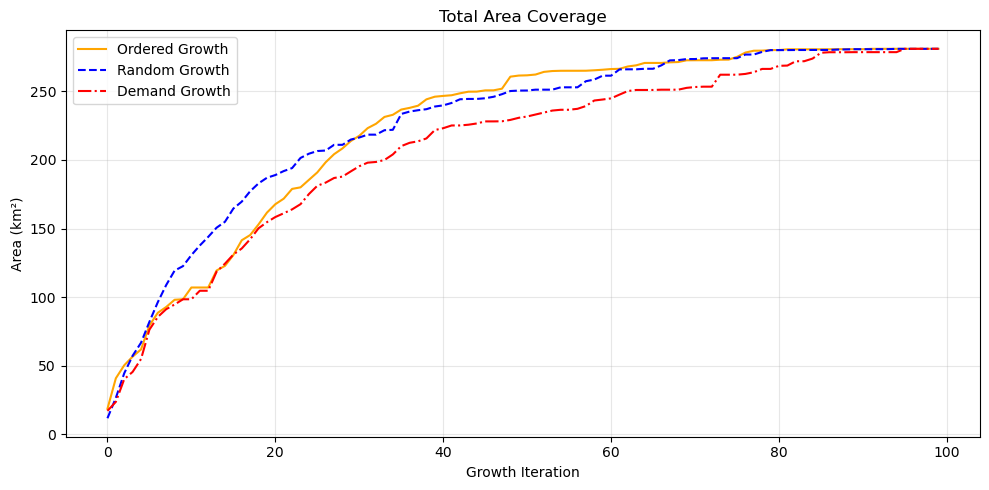

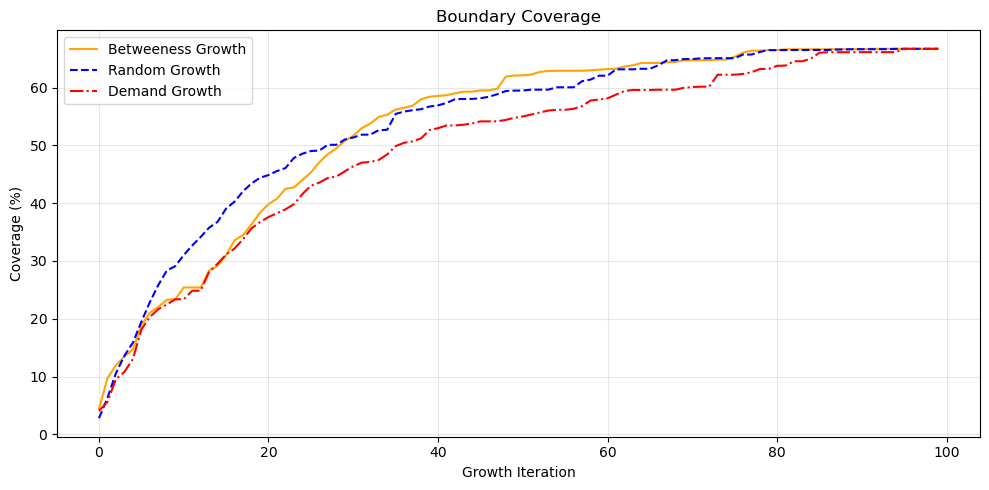

In [188]:
# # area
# target_crs = "EPSG:3857"
# boundary_proj = boundary.to_crs(target_crs)
# total_area = boundary_proj.unary_union.area  # total area in m²

# # Function to compute areas (km²) and percentage coverage for a list of buffers
# def compute_metrics(buffer_list):
#     areas = []
#     percentages = []
#     for gdf in buffer_list:
#         gdf_proj = gdf.to_crs(target_crs)
#         inter = gpd.overlay(gdf_proj, boundary_proj, how='intersection')
#         inter_area = inter.unary_union.area if not inter.empty else 0
#         areas.append(inter_area / 1e6)  # convert m² to km²
#         percentages.append((inter_area / total_area * 100) if total_area else 0)
#     return areas, percentages

# # Compute metrics for both buffer sets
# areas1, perc1 = compute_metrics(GTs_buffers)
# areas2, perc2 = compute_metrics(GTs_buffers_random)

# # Plot 1: Compare areas (in km²) for both buffer sets on one graph
# plt.figure(figsize=(10, 5))
# plt.plot(areas1, 'b-o', label='GTs_buffers Area (km²)')
# plt.plot(areas2, 'g-o', label='GTs_buffers_random Area (km²)')
# plt.xlabel('Buffer Index')
# plt.ylabel('Area (km²)')
# plt.title('Boundary Intersection Area Comparison')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Plot 2: Compare coverage percentages for both buffer sets on one graph
# plt.figure(figsize=(10, 5))
# plt.plot(perc1, 'r-s', label='GTs_buffers Coverage (%)')
# plt.plot(perc2, 'm-s', label='GTs_buffers_random Coverage (%)')
# plt.xlabel('Buffer Index')
# plt.ylabel('Coverage (%)')
# plt.title('Boundary Coverage Percentage Comparison')
# plt.legend()
# plt.tight_layout()
# plt.show()

# Area analysis cell
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}

if rerun or 'buffer_areas' not in analysis_results:
    target_crs = "EPSG:3857"
    boundary_proj = boundary.to_crs(target_crs)
    total_area = boundary_proj.unary_union.area

    def compute_metrics(buffer_list):
        areas = []
        percentages = []
        for gdf in buffer_list:
            gdf_proj = gdf.to_crs(target_crs)
            inter = gpd.overlay(gdf_proj, boundary_proj, how='intersection')
            inter_area = inter.unary_union.area if not inter.empty else 0
            areas.append(inter_area / 1e6)  # Convert m² to km²
            percentages.append((inter_area / total_area * 100) if total_area else 0)
        return areas, percentages

    buffer_metrics = {
        'buffer_areas': compute_metrics(GTs_buffers)[0],
        'buffer_percentages': compute_metrics(GTs_buffers)[1],
        'random_buffer_areas': compute_metrics(GTs_buffers_random)[0],
        'random_buffer_percentages': compute_metrics(GTs_buffers_random)[1],
        'demand_buffer_areas': compute_metrics(GTs_buffers_demand)[0],
        'demand_buffer_percentages': compute_metrics(GTs_buffers_demand)[1]
    }

    analysis_results.update(buffer_metrics)

    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)

# Plotting - Area (km²)
plt.figure(figsize=(10, 5))
plt.plot(
    analysis_results['buffer_areas'], 
    color='orange', 
    linestyle='-', 
    label='Ordered Growth'
)
plt.plot(
    analysis_results['random_buffer_areas'], 
    color='blue', 
    linestyle='--', 
    label='Random Growth'
)
plt.plot(
    analysis_results['demand_buffer_areas'], 
    color='red', 
    linestyle='-.', 
    label='Demand Growth'
)
plt.xlabel('Growth Iteration')
plt.ylabel('Area (km²)')
plt.title('Total Area Coverage')
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.3)
output_path = PATH["plots"] + "/" + placeid + "/area_coverage_km2.png"
plt.savefig(output_path, dpi=300)

plt.show()

# Plotting - Percentage Coverage
plt.figure(figsize=(10, 5))
plt.plot(
    analysis_results['buffer_percentages'], 
    color='orange', 
    linestyle='-', 
    label='Betweeness Growth'
)
plt.plot(
    analysis_results['random_buffer_percentages'], 
    color='blue', 
    linestyle='--', 
    label='Random Growth'
)
plt.plot(
    analysis_results['demand_buffer_percentages'], 
    color='red', 
    linestyle='-.', 
    label='Demand Growth'
)
plt.xlabel('Growth Iteration')
plt.ylabel('Coverage (%)')
plt.title('Boundary Coverage')
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.3)
output_path = PATH["plots"] + "/" + placeid + "/boundary_cov_percentage.png"
plt.savefig(output_path, dpi=300)

plt.show()


#### Streets coverage

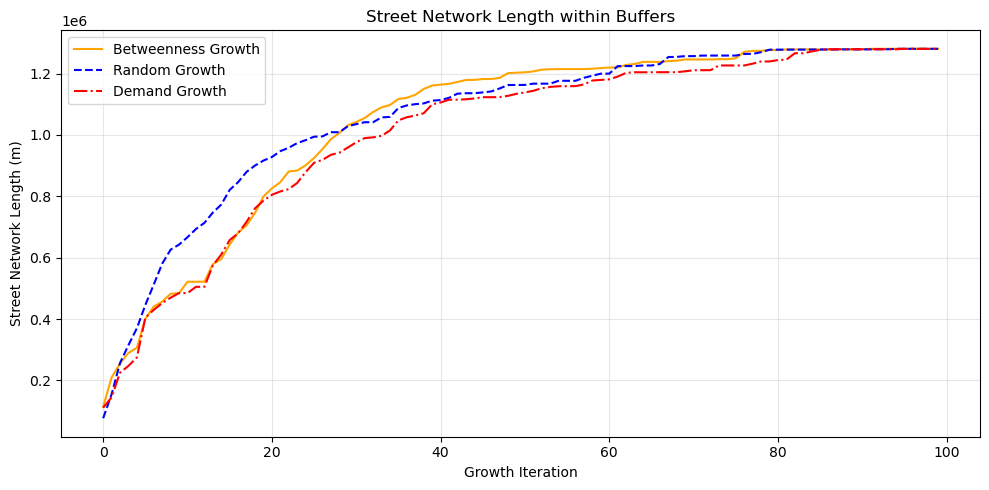

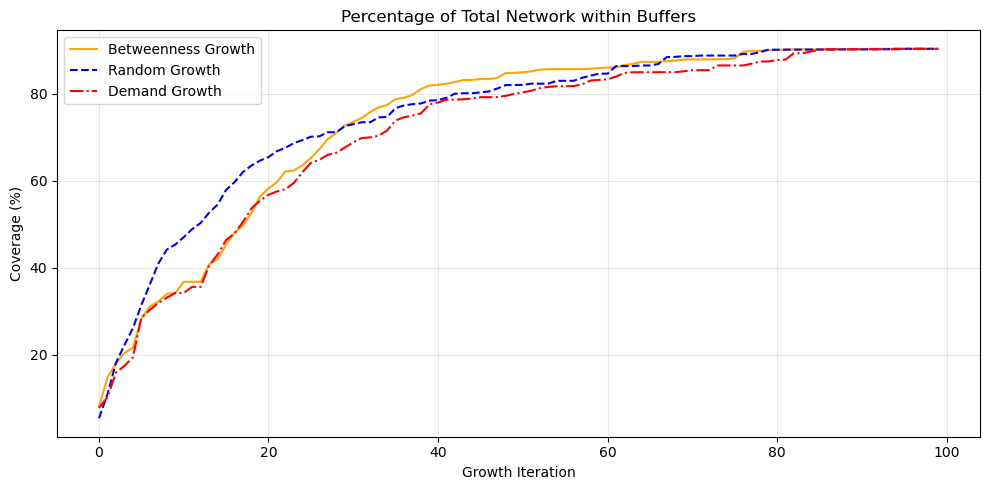

In [189]:
# network_crs = G_biketrackcarall_edges.crs
# total_network_length = G_biketrackcarall_edges["length"].sum()

# def compute_street_coverage(buffer_list):
#     lengths = []
#     percentages = []
#     for gdf in buffer_list:
#         # Reproject buffers to network CRS if needed
#         gdf_proj = gdf.to_crs(network_crs)
#         # Compute intersection between network and buffer
#         inter = gpd.overlay(G_biketrackcarall_edges, gdf_proj, how='intersection')
#         # Sum the existing "length" values from the intersected segments
#         seg_length = inter["length"].sum() if not inter.empty else 0
#         lengths.append(seg_length)
#         percentages.append((seg_length / total_network_length * 100) if total_network_length else 0)
#     return lengths, percentages

# # Compute metrics for both buffer sets
# net_lengths1, net_perc1 = compute_street_coverage(GTs_buffers)
# net_lengths2, net_perc2 = compute_street_coverage(GTs_buffers_random)

# # Plot 1: Compare network lengths (in meters) within each buffer
# plt.figure(figsize=(10, 5))
# plt.plot(net_lengths1, 'b-o', label='GTs_buffers Network (m)')
# plt.plot(net_lengths2, 'g-o', label='GTs_buffers_random Network (m)')
# plt.xlabel('Buffer Index')
# plt.ylabel('Network Length (m)')
# plt.title('Street Network Length within Buffers')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Plot 2: Compare network coverage percentages
# plt.figure(figsize=(10, 5))
# plt.plot(net_perc1, 'r-s', label='GTs_buffers Coverage (%)')
# plt.plot(net_perc2, 'm-s', label='GTs_buffers_random Coverage (%)')
# plt.xlabel('Buffer Index')
# plt.ylabel('Coverage (%)')
# plt.title('Percentage of Total Network within Buffers')
# plt.legend()
# plt.tight_layout()
# plt.show()
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}



if rerun or 'street_lengths' not in analysis_results:
    network_crs = G_biketrackcarall_edges.crs
    total_network_length = G_biketrackcarall_edges["length"].sum()

    # simplfy to reduce computation time
    proj_crs = network_crs if network_crs.is_projected else "EPSG:3857"
    edges_proj = G_biketrackcarall_edges.to_crs(proj_crs)
    edges_simpl = edges_proj.copy()
    edges_simpl.geometry = edges_proj.geometry.simplify(tolerance=10,
                                                         preserve_topology=True)
    edges_simpl = edges_simpl.to_crs(network_crs)

    def compute_street_coverage(buffer_list):
        lengths = []
        percentages = []
        for gdf in buffer_list:
            gdf_proj = gdf.to_crs(network_crs)
            # simplfy to reduce computation time
            gdf_proj = gdf.to_crs(proj_crs).copy()
            gdf_proj.geometry = gdf_proj.geometry.simplify(tolerance=10,
                                                           preserve_topology=True)
            gdf_proj = gdf_proj.to_crs(network_crs)
            
            inter = gpd.overlay(G_biketrackcarall_edges, gdf_proj, how='intersection')
            seg_length = inter["length"].sum() if not inter.empty else 0
            lengths.append(seg_length)
            percentages.append((seg_length / total_network_length * 100) if total_network_length else 0)
        return lengths, percentages

    street_metrics = {
        'street_cov_lengths': compute_street_coverage(GTs_buffers)[0],
        'street_cov_percentages': compute_street_coverage(GTs_buffers)[1],
        'random_street_cov_lengths': compute_street_coverage(GTs_buffers_random)[0],
        'random_street_cov_percentages': compute_street_coverage(GTs_buffers_random)[1],
        'demand_street_cov_lengths': compute_street_coverage(GTs_buffers_demand)[0],
        'demand_street_cov_percentages': compute_street_coverage(GTs_buffers_demand)[1]
    }

    analysis_results.update(street_metrics)

    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    df = pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()})
    df.to_csv(analysis_res_csv, index=False)

# Plot: Network Length within Buffers
plt.figure(figsize=(10, 5))
plt.plot(analysis_results['street_cov_lengths'], color='orange', linestyle='-', label='Betweenness Growth')
plt.plot(analysis_results['random_street_cov_lengths'], color='blue', linestyle='--', label='Random Growth')
plt.plot(analysis_results['demand_street_cov_lengths'], color='red', linestyle='-.', label='Demand Growth')
plt.xlabel('Growth Iteration')
plt.ylabel('Street Network Length (m)')
plt.title('Street Network Length within Buffers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/streets_within_cyclenet.png"
plt.savefig(output_path, dpi=300)

plt.show()

# Plot: Percentage of Network within Buffers
plt.figure(figsize=(10, 5))
plt.plot(analysis_results['street_cov_percentages'], color='orange', linestyle='-', label='Betweenness Growth')
plt.plot(analysis_results['random_street_cov_percentages'], color='blue', linestyle='--', label='Random Growth')
plt.plot(analysis_results['demand_street_cov_percentages'], color='red', linestyle='-.', label='Demand Growth')
plt.xlabel('Growth Iteration')
plt.ylabel('Coverage (%)')
plt.title('Percentage of Total Network within Buffers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/percentage_within_cyclenet.png"
plt.savefig(output_path, dpi=300)

plt.show()

#### Population coverage

Get population data from census, asign census data to buildings, find population within cycle route buffer

In [190]:
# # get lsoas and population
# lsoa_bound = gpd.read_file(PATH["data"] + "/" + placeid + "/lsoa_bound.gpkg")
# boundary = ox.geocode_to_gdf(placeinfo["nominatimstring"])
# lsoa_bound = gpd.clip(lsoa_bound, boundary)
# lsoa_bound = add_lsoa_population(lsoa_bound) # using 2011 census data

# # get buildings
# buildings = get_building_populations(lsoa_bound, boundary) ## add more detail??
# buildings = buildings.to_crs(epsg=4326)

In [191]:

# # pop_counts_GT = []
# # pop_counts_random_GT = []


# # # Function to calculate total pop_count within each buffer
# # def calculate_pop_count(buffers_list, buildings):
# #     pop_counts = []
# #     for buffer in buffers_list:
# #         intersecting_buildings = gpd.sjoin(buildings, buffer, predicate="intersects")
# #         total_pop = intersecting_buildings["pop_assigned"].sum()
# #         pop_counts.append(total_pop)
# #     return pop_counts

# # # Calculate for both sets of buffers
# # pop_counts_GT = calculate_pop_count(GTs_buffers, buildings)
# # pop_counts_random_GT = calculate_pop_count(GTs_buffers_random, buildings)

# # plt.figure(figsize=(10, 5))
# # buffer_indices = np.arange(len(GTs_buffers))  # Common x-axis indices for both datasets

# # plt.plot(buffer_indices, pop_counts_GT, label="GTs Buffers", linestyle='-', color='blue')
# # plt.plot(buffer_indices, pop_counts_random_GT, label="Random GTs Buffers", linestyle='--', color='orange')

# # plt.xlabel("Buffer Index")
# # plt.ylabel("Total Population Count")
# # plt.title("Comparison of Population Within Buffers")
# # plt.legend()
# # plt.grid(True)
# # plt.show()
# if os.path.exists(analysis_res_pickle):
#     with open(analysis_res_pickle, 'rb') as f:
#         analysis_results = pickle.load(f)
# else:
#     analysis_results = {}

# if rerun or 'pop_counts_GT' not in analysis_results:
#     def calculate_pop_count(buffers_list, buildings):
#         pop_counts = []
#         for buffer in buffers_list:
#             intersecting_buildings = gpd.sjoin(buildings, buffer, predicate="intersects")
#             pop_counts.append(intersecting_buildings["pop_assigned"].sum())
#         return pop_counts

#     pop_metrics = {
#         'pop_counts_GT': calculate_pop_count(GTs_buffers, buildings),
#         'pop_counts_random_GT': calculate_pop_count(GTs_buffers_random, buildings),
#         'pop_counts_demand_GT': calculate_pop_count(GTs_buffers_demand, buildings)
#     }

#     analysis_results.update(pop_metrics)

#     with open(analysis_res_pickle, 'wb') as f:
#         pickle.dump(analysis_results, f)
#     df = pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()})
#     df.to_csv(analysis_res_csv, index=False)

# # Plotting
# plt.figure(figsize=(10, 5))
# buffer_indices = np.arange(len(GTs_buffers))

# plt.plot(
#     buffer_indices,
#     analysis_results['pop_counts_GT'],
#     label="Betweenness Growth",
#     linestyle='-',
#     color='orange'
# )
# plt.plot(
#     buffer_indices,
#     analysis_results['pop_counts_random_GT'],
#     label="Random Growth",
#     linestyle='--',
#     color='blue'
# )
# plt.plot(
#     buffer_indices,
#     analysis_results['pop_counts_demand_GT'],
#     label="Demand-based Growth",
#     linestyle='-.',
#     color='red'
# )

# plt.xlabel("Buffer Index")
# plt.ylabel("Total Population Count")
# plt.title("Population Within Buffers Over Investment Iterations")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


#### POI coverage

##### Seed points

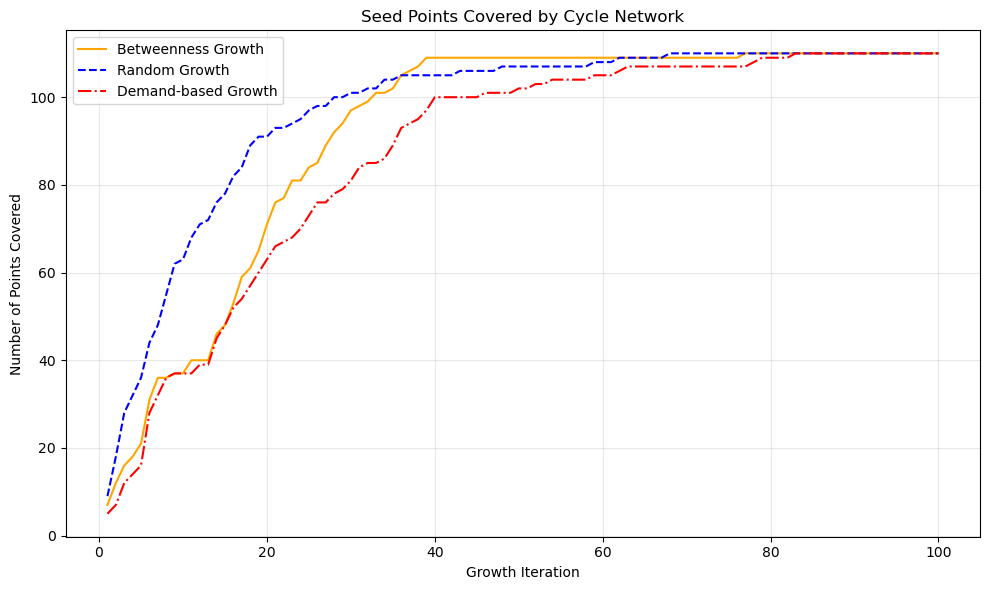

In [192]:
# counts_buffers = []
# counts_random = []

# # Iterate over each buffer GeoDataFrame in GTs_buffers
# for gdf in GTs_buffers:
#     # Create a union of all polygons in the buffer gdf (if there is more than one)
#     buffer_union = gdf.unary_union
#     # Count the points in combined_points that fall within this union
#     count = combined_points.within(buffer_union).sum()
#     counts_buffers.append(count)

# # Do the same for GTs_buffers_random
# for gdf in GTs_buffers_random:
#     buffer_union = gdf.unary_union
#     count = combined_points.within(buffer_union).sum()
#     counts_random.append(count)

# # Plotting the results on a line graph
# plt.figure(figsize=(10, 6))
# x_vals = range(1, len(counts_buffers) + 1)  # Assuming you want x-axis as buffer index

# plt.plot(x_vals, counts_buffers, marker='o', label='GTs_buffers')
# plt.plot(x_vals, counts_random, marker='o', label='GTs_buffers_random')

# plt.xlabel('Buffer Index')
# plt.ylabel('Number of Points Covered')
# plt.title('Points Covered by Each Buffer')
# plt.legend()
# plt.grid(True)
# plt.show()
# Seed point analysis cell
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}  

if rerun or 'points_covered_GT' not in analysis_results:
    point_metrics = {
        'points_covered_GT': [
            combined_points.within(gdf.unary_union).sum()
            for gdf in GTs_buffers
        ],
        'points_covered_random': [
            combined_points.within(gdf.unary_union).sum()
            for gdf in GTs_buffers_random
        ],
        'points_covered_demand': [
            combined_points.within(gdf.unary_union).sum()
            for gdf in GTs_buffers_demand
        ]
    }
    analysis_results.update(point_metrics)

    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)

# Plotting
plt.figure(figsize=(10, 6))
x_vals = range(1, len(analysis_results['points_covered_GT']) + 1)

plt.plot(
    x_vals,
    analysis_results['points_covered_GT'],
    color='orange',
    linestyle='-',
    label='Betweenness Growth'
)
plt.plot(
    x_vals,
    analysis_results['points_covered_random'],
    color='blue',
    linestyle='--',
    label='Random Growth'
)
plt.plot(
    x_vals,
    analysis_results['points_covered_demand'],
    color='red',
    linestyle='-.',
    label='Demand-based Growth'
)

plt.xlabel('Growth Iteration')
plt.ylabel('Number of Points Covered')
plt.title('Seed Points Covered by Cycle Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/seed_point_coverage.png"
plt.savefig(output_path, dpi=300)

plt.show()


##### LTN Points

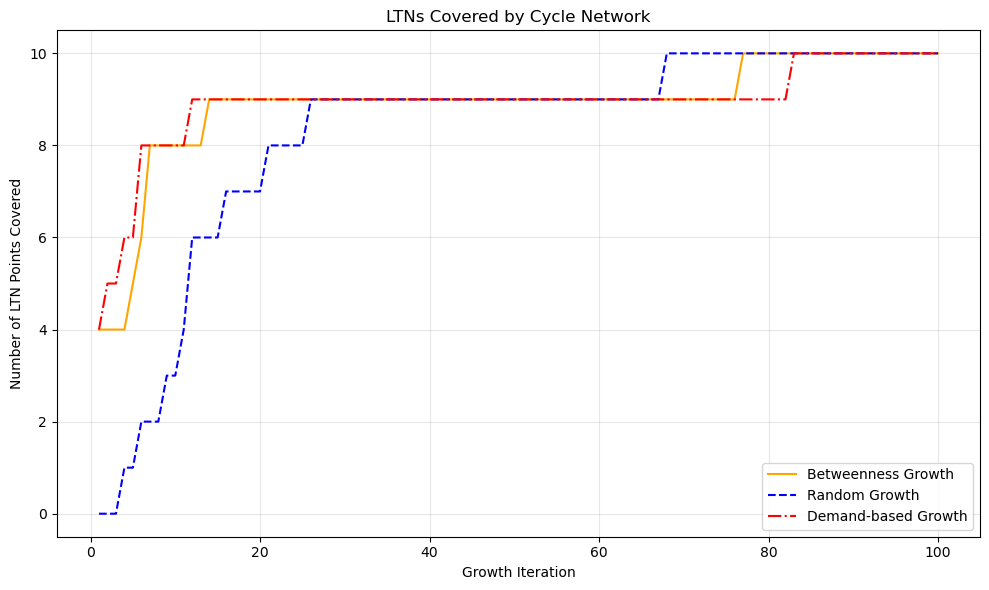

In [193]:
# counts_buffers = []
# counts_random = []

# # Iterate over each buffer GeoDataFrame in GTs_buffers
# for gdf in GTs_buffers:
#     # Create a union of all polygons in the buffer gdf (if there is more than one)
#     buffer_union = gdf.unary_union
#     # Count the points that fall within this union
#     count = ltn_points.within(buffer_union).sum()
#     counts_buffers.append(count)

# # Do the same for GTs_buffers_random
# for gdf in GTs_buffers_random:
#     buffer_union = gdf.unary_union
#     count = ltn_points.within(buffer_union).sum()
#     counts_random.append(count)

# # Plotting the results on a line graph
# plt.figure(figsize=(10, 6))
# x_vals = range(1, len(counts_buffers) + 1)  # Assuming you want x-axis as buffer index

# plt.plot(x_vals, counts_buffers, marker='o', label='GTs_buffers')
# plt.plot(x_vals, counts_random, marker='o', label='GTs_buffers_random')

# plt.xlabel('Buffer Index')
# plt.ylabel('Number of Points Covered')
# plt.title('Points Covered by Each Buffer')
# plt.legend()
# plt.grid(True)
# plt.show()

# LTN point coverage analysis cell
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {} 

if rerun or 'ltn_points_covered_GT' not in analysis_results:
    def compute_ltn_coverage(buffers_list):
        return [
            ltn_points.within(gdf.unary_union).sum()
            for gdf in buffers_list
        ]
    
    analysis_results.update({
        'ltn_points_covered_GT': compute_ltn_coverage(GTs_buffers),
        'ltn_points_covered_random': compute_ltn_coverage(GTs_buffers_random),
        'ltn_points_covered_demand': compute_ltn_coverage(GTs_buffers_demand)
    })

    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)

# Plotting
plt.figure(figsize=(10, 6))
x_vals = range(1, len(analysis_results['ltn_points_covered_GT']) + 1)

plt.plot(
    x_vals,
    analysis_results['ltn_points_covered_GT'],
    color='orange',
    linestyle='-',
    label='Betweenness Growth'
)
plt.plot(
    x_vals,
    analysis_results['ltn_points_covered_random'],
    color='blue',
    linestyle='--',
    label='Random Growth'
)
plt.plot(
    x_vals,
    analysis_results['ltn_points_covered_demand'],
    color='red',
    linestyle='-.',
    label='Demand-based Growth'
)

plt.xlabel('Growth Iteration')
plt.ylabel('Number of LTN Points Covered')
plt.title('LTNs Covered by Cycle Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/ltns_coverage.png"
plt.savefig(output_path, dpi=300)

plt.show()


##### All neighbourhoods

In [194]:
# think about how if we were to create future LTNs, where could these go based purely on making more cycling safe?

# should these be where the most cycling is on? or which area has the longest bit of cycle network added? 

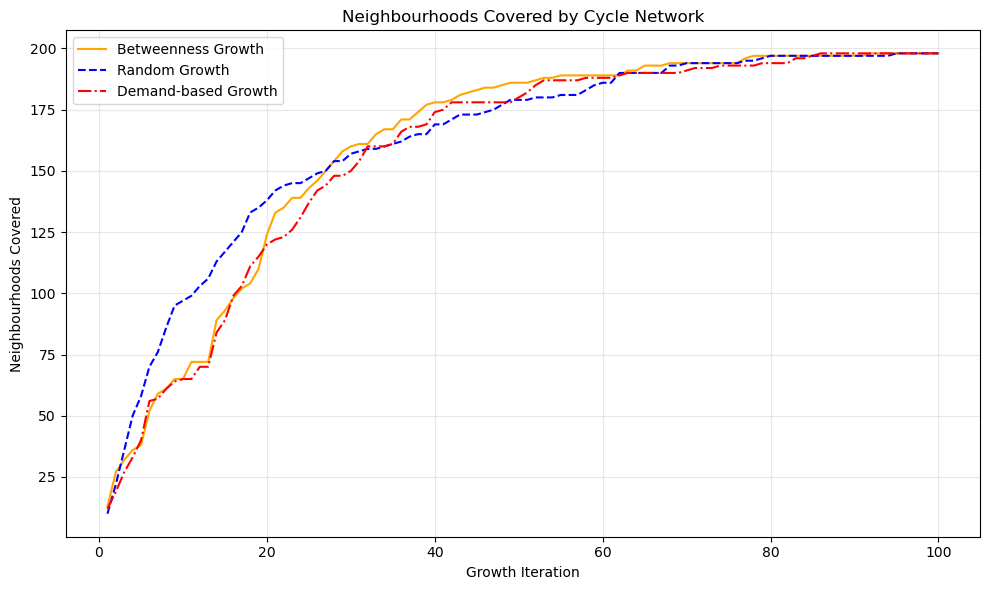

In [195]:
# counts_buffers = []
# counts_random = []

# # Iterate over each buffer GeoDataFrame in GTs_buffers
# for gdf in GTs_buffers:
#     # Create a union of all polygons in the buffer gdf (if there is more than one)
#     buffer_union = gdf.unary_union
#     # Count the points in combined_points that fall within this union
#     count = all_neighbourhoods_centroids.within(buffer_union).sum()
#     counts_buffers.append(count)

# # Do the same for GTs_buffers_random
# for gdf in GTs_buffers_random:
#     buffer_union = gdf.unary_union
#     count = all_neighbourhoods_centroids.within(buffer_union).sum()
#     counts_random.append(count)

# # Plotting the results on a line graph
# plt.figure(figsize=(10, 6))
# x_vals = range(1, len(counts_buffers) + 1)  # Assuming you want x-axis as buffer index

# plt.plot(x_vals, counts_buffers, marker='o', label='GTs_buffers')
# plt.plot(x_vals, counts_random, marker='o', label='GTs_buffers_random')

# plt.xlabel('Buffer Index')
# plt.ylabel('Number of Points Covered')
# plt.title('Points Covered by Each Buffer')
# plt.legend()
# plt.grid(True)
# plt.show()
# Neighborhood centroids analysis cell
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {} 

if rerun or 'neighborhood_points_covered_GT' not in analysis_results:
    def count_neighborhood_coverage(buffers_list):
        return [
            all_neighbourhoods_centroids.within(gdf.unary_union).sum()
            for gdf in buffers_list
        ]

    neighborhood_metrics = {
        'neighborhood_points_covered_GT': count_neighborhood_coverage(GTs_buffers),
        'neighborhood_points_covered_random': count_neighborhood_coverage(GTs_buffers_random),
        'neighborhood_points_covered_demand': count_neighborhood_coverage(GTs_buffers_demand)
    }

    analysis_results.update(neighborhood_metrics)
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)

# Plotting
plt.figure(figsize=(10, 6))
x_vals = range(1, len(analysis_results['neighborhood_points_covered_GT']) + 1)

plt.plot(
    x_vals,
    analysis_results['neighborhood_points_covered_GT'],
    color='orange',
    linestyle='-',
    label='Betweenness Growth'
)
plt.plot(
    x_vals,
    analysis_results['neighborhood_points_covered_random'],
    color='blue',
    linestyle='--',
    label='Random Growth'
)
plt.plot(
    x_vals,
    analysis_results['neighborhood_points_covered_demand'],
    color='red',
    linestyle='-.',
    label='Demand-based Growth'
)

plt.xlabel('Growth Iteration')
plt.ylabel('Neighbourhoods Covered')
plt.title('Neighbourhoods Covered by Cycle Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/neighbourhoods_coverage.png"
plt.savefig(output_path, dpi=300)

plt.show()


### Overlap

Overlap with existing infrastructure. Finding how much of the existing network we overlap, in terms of edges, distance, and % of total network

In [196]:
# def compare_against_reference(graph_list1, graph_list2, reference_graph):
#     """
#     Compare two lists of graphs against a reference, calculating both:
#     1. How much of the reference is covered by each graph (original metric)
#     2. How much of each graph is covered by the reference (reverse metric)
#     """
#     def calculate_both_ways(graph, reference):
#         # Original: how much of reference is covered by graph
#         orig_size_pct, orig_len_pct, orig_edges, orig_len = calculate_overlap_percentages(reference, graph)
#         # Reverse: how much of graph is covered by reference
#         rev_size_pct, rev_len_pct, rev_edges, rev_len = calculate_overlap_percentages(graph, reference)
#         return (orig_size_pct, orig_len_pct, orig_edges, orig_len,
#                 rev_size_pct, rev_len_pct, rev_edges, rev_len)
    
#     metrics_list1 = [calculate_both_ways(g, reference_graph) for g in graph_list1]
#     metrics_list2 = [calculate_both_ways(g, reference_graph) for g in graph_list2]
    
#     return metrics_list1, metrics_list2

# def plot_comparison(metrics_GTs, metrics_GTs_random):
#     """Plot comparison with separate views for both metrics"""
#     fig, axes = plt.subplots(4, 1, figsize=(12, 16))
    
#     # Original percentage metrics (how much of REFERENCE is covered)
#     axes[0].plot([m[0] for m in metrics_GTs], 'b-', label='GTs Size (Ref Covered)')
#     axes[0].plot([m[0] for m in metrics_GTs_random], 'r--', label='GTs_random Size (Ref Covered)')
#     axes[0].plot([m[1] for m in metrics_GTs], 'g-', label='GTs Length (Ref Covered)')
#     axes[0].plot([m[1] for m in metrics_GTs_random], 'm--', label='GTs_random Length (Ref Covered)')
#     axes[0].set_title('Percentage of Reference Covered')
#     axes[0].set_ylabel('Percentage')
#     axes[0].legend()
#     axes[0].grid(True)
    
#     # Reverse percentage metrics (how much of NETWORK is covered by reference)
#     axes[1].plot([m[4] for m in metrics_GTs], 'b-', label='GTs Size (Network Covered)')
#     axes[1].plot([m[4] for m in metrics_GTs_random], 'r--', label='GTs_random Size (Network Covered)')
#     axes[1].plot([m[5] for m in metrics_GTs], 'g-', label='GTs Length (Network Covered)')
#     axes[1].plot([m[5] for m in metrics_GTs_random], 'm--', label='GTs_random Length (Network Covered)')
#     axes[1].set_title('Percentage of Network Covered by Reference')
#     axes[1].set_ylabel('Percentage')
#     axes[1].legend()
#     axes[1].grid(True)
    
#     # Raw edge counts
#     axes[2].plot([m[2] for m in metrics_GTs], 'b-', label='GTs Edges (Ref Covered)')
#     axes[2].plot([m[2] for m in metrics_GTs_random], 'r--', label='GTs_random Edges (Ref Covered)')
#     axes[2].plot([m[6] for m in metrics_GTs], 'g-', label='GTs Edges (Network Covered)')
#     axes[2].plot([m[6] for m in metrics_GTs_random], 'm--', label='GTs_random Edges (Network Covered)')
#     axes[2].set_title('Raw Edge Counts')
#     axes[2].set_ylabel('Edges')
#     axes[2].legend()
#     axes[2].grid(True)
    
#     # Raw lengths
#     axes[3].plot([m[3] for m in metrics_GTs], 'b-', label='GTs Length (Ref Covered)')
#     axes[3].plot([m[3] for m in metrics_GTs_random], 'r--', label='GTs_random Length (Ref Covered)')
#     axes[3].plot([m[7] for m in metrics_GTs], 'g-', label='GTs Length (Network Covered)')
#     axes[3].plot([m[7] for m in metrics_GTs_random], 'm--', label='GTs_random Length (Network Covered)')
#     axes[3].set_title('Raw Length Overlap')
#     axes[3].set_ylabel('Length')
#     axes[3].legend()
#     axes[3].grid(True)
    
#     plt.tight_layout()
#     plt.show()

# reference = G_biketrack  # Your reference infrastructure
# metrics_GTs, metrics_GTs_random = compare_against_reference(GTs, GTs_random, reference)
# plot_comparison(metrics_GTs, metrics_GTs_random)

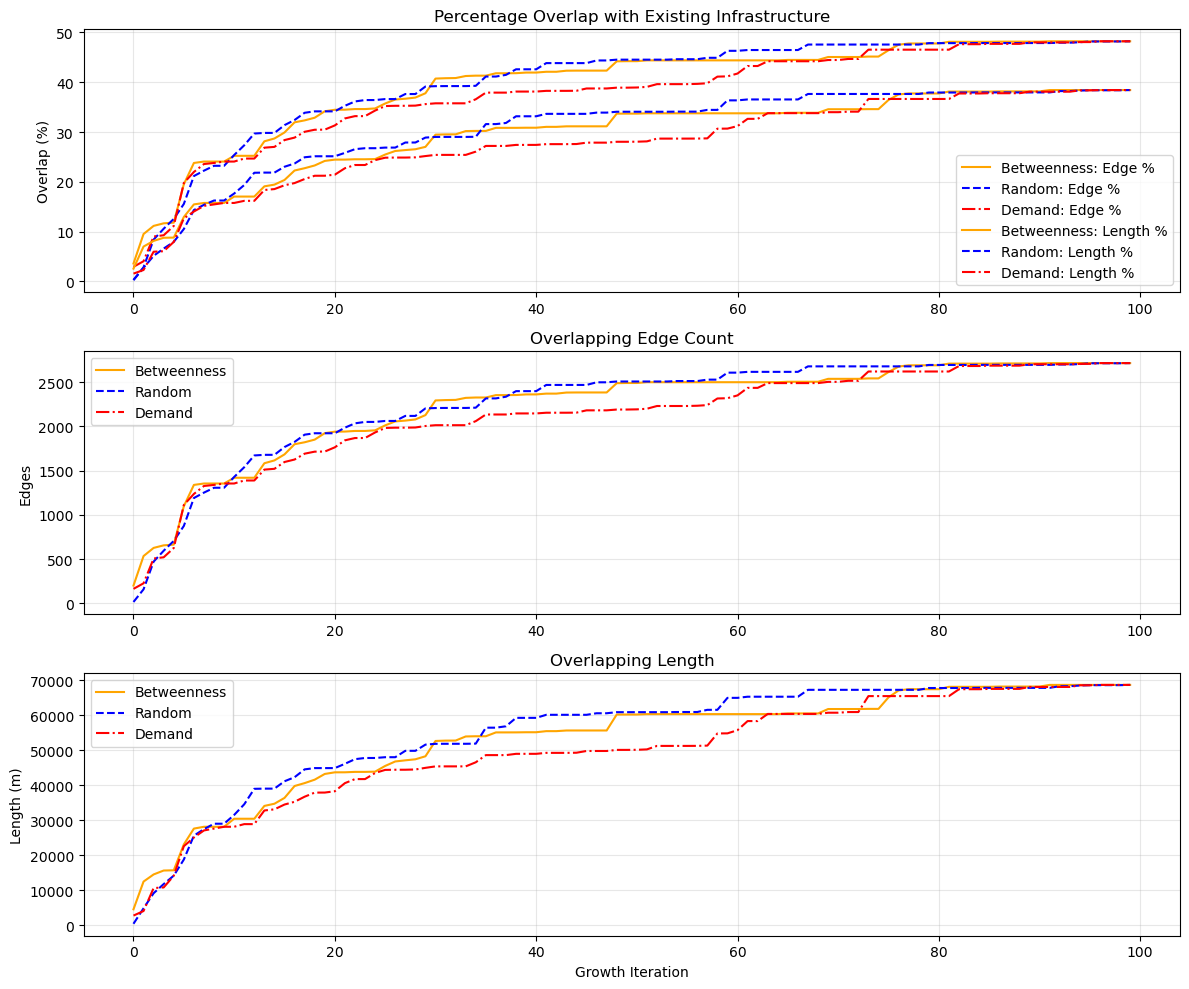

In [197]:
# def calculate_overlap_percentages(G_biketrack, G):
#     # Calculate edge overlap and length overlap
#     overlapping_edges = 0
#     overlapping_length = 0
#     total_edges = G_biketrack.number_of_edges()
#     total_length = sum(data['length'] for u, v, data in G_biketrack.edges(data=True))
    
#     for u, v, data in G_biketrack.edges(data=True):
#         if G.has_edge(u, v):
#             overlapping_edges += 1
#             overlapping_length += data['length']
    
#     if total_edges == 0:
#         size_percent = 0.0
#     else:
#         size_percent = (overlapping_edges / total_edges) * 100
    
#     if total_length == 0:
#         length_percent = 0.0
#     else:
#         length_percent = (overlapping_length / total_length) * 100
    
#     return size_percent, length_percent, overlapping_edges, overlapping_length


# def compare_against_existing(graph_list1, graph_list2, reference_graph):
#     """
#     Compare two lists of graphs against a common reference graph.
#     Returns metrics for both lists compared to the reference.
#     """
#     # Calculate metrics for both lists against the reference
#     metrics_list1 = [calculate_overlap_percentages(g, reference_graph) for g in graph_list1]
#     metrics_list2 = [calculate_overlap_percentages(g, reference_graph) for g in graph_list2]
    
#     return metrics_list1, metrics_list2

# def plot_comparison(metrics_GTs, metrics_GTs_random):
#     """Plot comparison between GTs and GTs_random against G_biketrack"""
#     fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
    
#     # Percentage plot
#     ax1.plot([m[0] for m in metrics_GTs], 'b-', label='GTs Size Overlap (%)')
#     ax1.plot([m[0] for m in metrics_GTs_random], 'r--', label='GTs_random Size Overlap (%)')
#     ax1.plot([m[1] for m in metrics_GTs], 'g-', label='GTs Length Overlap (%)')
#     ax1.plot([m[1] for m in metrics_GTs_random], 'm--', label='GTs_random Length Overlap (%)')
#     ax1.set_title('Percentage Overlap with Existing Cycle Infrastructure (Including LTNs)')
#     ax1.set_ylabel('Percentage')
#     ax1.legend()
#     ax1.grid(True)
    
#     # Edge count plot
#     ax2.plot([m[2] for m in metrics_GTs], 'b-', label='GTs Overlapping Edges')
#     ax2.plot([m[2] for m in metrics_GTs_random], 'r--', label='GTs_random Overlapping Edges')
#     ax2.set_title('Edge Overlap Comparison')
#     ax2.set_ylabel('Edge Count')
#     ax2.legend()
#     ax2.grid(True)
    
#     # Length plot
#     ax3.plot([m[3] for m in metrics_GTs], 'g-', label='GTs Overlapping Length')
#     ax3.plot([m[3] for m in metrics_GTs_random], 'm--', label='GTs_random Overlapping Length')
#     ax3.set_title('Length Overlap Comparison')
#     ax3.set_ylabel('Length Units')
#     ax3.legend()
#     ax3.grid(True)
    
#     plt.tight_layout()
#     plt.show()



# metrics_GTs, metrics_GTs_random = compare_against_existing(GTs, GTs_random, G_biketrack)
# plot_comparison(metrics_GTs, metrics_GTs_random)
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}

if rerun or 'overlap_size_percent_GTs' not in analysis_results:
    def calculate_overlap_percentages(G_ref, G):
        overlapping_edges = 0
        overlapping_length = 0
        total_edges = G_ref.number_of_edges()
        total_length = sum(data.get('length', 0) for _, _, data in G_ref.edges(data=True))

        for u, v, data in G_ref.edges(data=True):
            if G.has_edge(u, v):
                overlapping_edges += 1
                overlapping_length += data.get('length', 0)

        size_percent = (overlapping_edges / total_edges * 100) if total_edges else 0
        length_percent = (overlapping_length / total_length * 100) if total_length else 0

        return size_percent, length_percent, overlapping_edges, overlapping_length

    def get_metrics(graph_list, ref_graph):
        return [calculate_overlap_percentages(ref_graph, g) for g in graph_list]

    metrics_betweenness = get_metrics(GTs, G_biketrack)
    metrics_random = get_metrics(GTs_random, G_biketrack)
    metrics_demand = get_metrics(GTs_demand, G_biketrack)

    overlap_metrics = {
        # Betweenness
        'overlap_size_percent_GTs': [m[0] for m in metrics_betweenness],
        'overlap_length_percent_GTs': [m[1] for m in metrics_betweenness],
        'overlap_edges_GTs': [m[2] for m in metrics_betweenness],
        'overlap_length_GTs': [m[3] for m in metrics_betweenness],

        # Random
        'overlap_size_percent_random': [m[0] for m in metrics_random],
        'overlap_length_percent_random': [m[1] for m in metrics_random],
        'overlap_edges_random': [m[2] for m in metrics_random],
        'overlap_length_random': [m[3] for m in metrics_random],

        # Demand
        'overlap_size_percent_demand': [m[0] for m in metrics_demand],
        'overlap_length_percent_demand': [m[1] for m in metrics_demand],
        'overlap_edges_demand': [m[2] for m in metrics_demand],
        'overlap_length_demand': [m[3] for m in metrics_demand]
    }

    analysis_results.update(overlap_metrics)
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)


def plot_comparison(analysis_results):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

    # 1. Percentage Overlap
    ax1.plot(analysis_results['overlap_size_percent_GTs'], color='orange', linestyle='-', label='Betweenness: Edge %')
    ax1.plot(analysis_results['overlap_size_percent_random'], color='blue', linestyle='--',  label='Random: Edge %')
    ax1.plot(analysis_results['overlap_size_percent_demand'], color='red', linestyle='-.',  label='Demand: Edge %')

    ax1.plot(analysis_results['overlap_length_percent_GTs'], color='orange', linestyle='-',  label='Betweenness: Length %')
    ax1.plot(analysis_results['overlap_length_percent_random'], color='blue', linestyle='--', label='Random: Length %')
    ax1.plot(analysis_results['overlap_length_percent_demand'], color='red', linestyle='-.', label='Demand: Length %')

    ax1.set_title('Percentage Overlap with Existing Infrastructure')
    ax1.set_ylabel('Overlap (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Overlapping Edge Count
    ax2.plot(analysis_results['overlap_edges_GTs'], color='orange', linestyle='-',  label='Betweenness')
    ax2.plot(analysis_results['overlap_edges_random'], color='blue', linestyle='--', label='Random')
    ax2.plot(analysis_results['overlap_edges_demand'], color='red', linestyle='-.',  label='Demand')

    ax2.set_title('Overlapping Edge Count')
    ax2.set_ylabel('Edges')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Overlapping Length
    ax3.plot(analysis_results['overlap_length_GTs'], color='orange', linestyle='-',  label='Betweenness')
    ax3.plot(analysis_results['overlap_length_random'], color='blue', linestyle='--',  label='Random')
    ax3.plot(analysis_results['overlap_length_demand'], color='red', linestyle='-.',  label='Demand')

    ax3.set_title('Overlapping Length')
    ax3.set_ylabel('Length (m)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.xlabel('Growth Iteration')
    plt.tight_layout()
    output_path = PATH["plots"] + "/" + placeid + "/overlap_with_existing.png"
    plt.savefig(output_path, dpi=300)

    plt.show()


plot_comparison(analysis_results)


In [198]:
# metrics_GTs, metrics_GTs_random = compare_against_existing(GTs, GTs_random, G_biketrack_no_ltn) # no differance?
# plot_comparison(metrics_GTs, metrics_GTs_random)

In [199]:
# #### to explore it

# # work in meters
# G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)
# G_edges = G_edges.to_crs(epsg=3857)
# G_biketrack_edges['geometry'] = G_biketrack_edges.geometry.buffer(1)
# G_edges['geometry'] = G_edges.geometry.buffer(1)
# joined = gpd.sjoin(G_biketrack_edges, G_edges, how="inner", predicate="intersects", lsuffix="_biketrack", rsuffix="_edge")

# joined.explore()

### Directness

Directness (Directness=Total Sum of Network Distances/Total Sum of Euclidean Distances​)

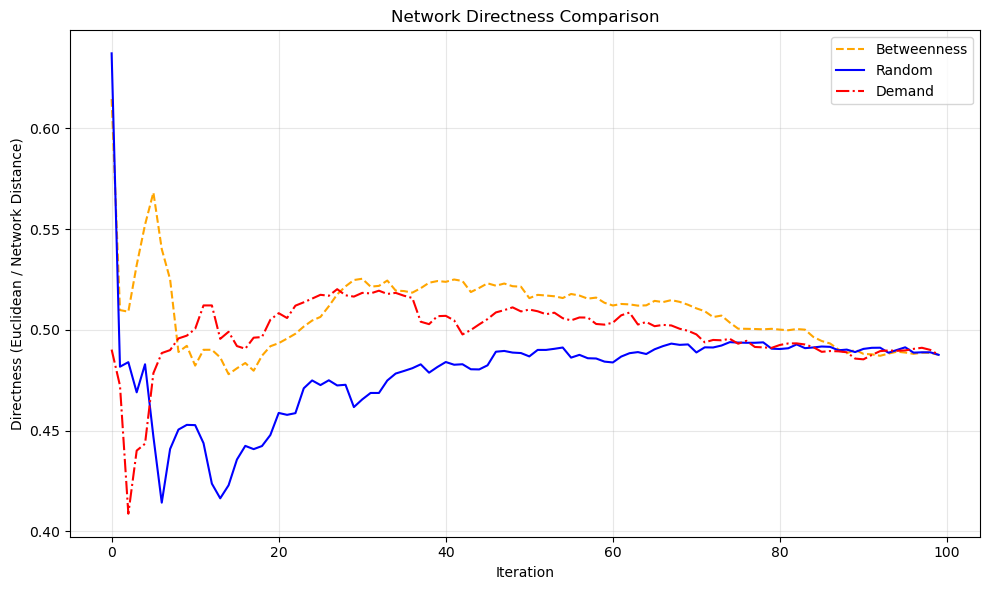

In [200]:
# net_dist = []
# eucl_dist = []
# directness = []

# for G in GT_abstracts:
#     total_net_dist = sum(data.get('eucl_dist', 0) for _, _, data in G.edges(data=True))
#     total_eucl_dist = sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True))
#     net_dist.append(total_net_dist)
#     eucl_dist.append(total_eucl_dist)
#     if total_net_dist != 0:
#         ratio = total_eucl_dist / total_net_dist
#     else:
#         ratio = None
#     directness.append(ratio)


# net_dist_random = []
# eucl_dist_random = []
# directness_random = []

# for G in GT_abstracts_random:
#     total_net_dist = sum(data.get('eucl_dist', 0) for _, _, data in G.edges(data=True))
#     total_eucl_dist = sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True))
#     net_dist_random.append(total_net_dist)
#     eucl_dist_random.append(total_eucl_dist)
#     if total_net_dist != 0:
#         ratio = total_eucl_dist / total_net_dist
#     else:
#         ratio = None
#     directness_random.append(ratio)



# # Plotting 
# plt.figure(figsize=(10, 6))
# plt.plot(directness, linestyle='-', color='blue', label='Betweeness')
# plt.plot(directness_random, linestyle='--', color='orange', label='Random')
# plt.xlabel('Graph Index')
# plt.ylabel('Directness (Euclidean / Network Distance)')
# plt.title('Total Network Directness')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Directness analysis 
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}

if rerun or 'directness_demand' not in analysis_results:
    directness_metrics = {
        # Betweenness
        'directness_net': [
            sum(data.get('eucl_dist', 0) for _, _, data in G.edges(data=True))
            for G in GT_abstracts
        ],
        'directness_eucl': [
            sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True))
            for G in GT_abstracts
        ],
        'directness': [
            (sum(data.get('eucl_dist', 0) for _, _, data in G.edges(data=True)) / 
            sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True)))
            if sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True)) != 0 else None
            for G in GT_abstracts
        ],

        # Random
        'directness_net_random': [
            sum(data.get('eucl_dist', 0) for _, _, data in G.edges(data=True))
            for G in GT_abstracts_random
        ],
        'directness_eucl_random': [
            sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True))
            for G in GT_abstracts_random
        ],
        'directness_random': [
            (sum(data.get('eucl_dist', 0) for _, _, data in G.edges(data=True)) / 
             sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True)))
            if sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True)) != 0 else None
            for G in GT_abstracts_random
        ],

        # Demand
        'directness_net_demand': [
            sum(data.get('eucl_dist', 0) for _, _, data in G.edges(data=True))
            for G in GT_abstracts_demand
        ],
        'directness_eucl_demand': [
            sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True))
            for G in GT_abstracts_demand
        ],
        'directness_demand': [
            (sum(data.get('eucl_dist', 0) for _, _, data in G.edges(data=True)) / 
             sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True)))
            if sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True)) != 0 else None
            for G in GT_abstracts_demand
        ]
    }

    analysis_results.update(directness_metrics)
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)

plt.figure(figsize=(10, 6))
plt.plot(
    analysis_results['directness'],
    linestyle='--', 
    color='orange', 
    label='Betweenness'
)
plt.plot(
    analysis_results['directness_random'],
    linestyle='-', 
    color='blue', 
    label='Random'
)
plt.plot(
    analysis_results['directness_demand'],
    linestyle='-.', 
    color='red', 
    label='Demand'
)

plt.xlabel('Iteration')
plt.ylabel('Directness (Euclidean / Network Distance)')
plt.title('Network Directness Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_path = PATH["plots"] + "/" + placeid + "/directness.png"
plt.savefig(output_path, dpi=300)
plt.show()


In [201]:
# calcaulate directness of existing network to compare against...

## Efficiency

### Global

In [202]:
# ## edit plotting
# def calculate_efficiency(G):
#     """Calculate global network efficiency using formula E = 1/(N(N-1)) * Σ 1/d_ij"""
#     # Convert to undirected graph
#     undirected_G = nx.Graph(G)
#     try:
#         return nx.global_efficiency(undirected_G)
#     except nx.NetworkXError:
#         return 0  # Handle disconnected graphs

# def plot_efficiency_comparison(GTs, GTs_random):
#     """Calculate and plot global efficiency for both graph lists"""
#     # Calculate efficiencies
#     eff_GTs = [calculate_efficiency(G) for G in GTs]
#     eff_random = [calculate_efficiency(G) for G in GTs_random]
    
#     # Create plot
#     plt.figure(figsize=(10, 6))
#     plt.plot(eff_GTs, 'b-', linewidth=2, label='GTs Efficiency')
#     plt.plot(eff_random, 'r--', linewidth=2, label='GTs_random Efficiency')
    
#     plt.title('Global Network Efficiency Comparison\n$E = \\frac{1}{N(N-1)}\\sum_{i\\neq j} \\frac{1}{d_{ij}}$')
#     plt.ylabel('Global Efficiency')
#     plt.xlabel('Graph Instance Index')
#     plt.legend()
#     plt.grid(True)
#     plt.ylim(0, 1)
#     plt.tight_layout()
#     plt.show()

# # Usage example:
# plot_efficiency_comparison(GTs, GTs_random)

In [203]:
def calculate_global_efficiency(G, numnodepairs=500, normalized=True, weight='weight', debug=False):
    """Calculates global network efficiency for a graph G."""
    if G is None or len(G) < 2:
        return 0.0
    
    nodes = list(G.nodes)
    N = len(nodes)
    
    if N > numnodepairs:
        sampled_nodes = random.sample(nodes, numnodepairs)
    else:
        sampled_nodes = nodes
    S = len(sampled_nodes)
    if S < 2:
        return 0.0
    
    total_efficiency = 0.0
    considered_pairs = S * (S - 1)  
    
    for u in sampled_nodes:
        try:
            lengths = nx.single_source_dijkstra_path_length(G, u, weight=weight)
            for v in sampled_nodes:
                if u == v: continue
                d = lengths.get(v, float('inf'))
                if 0 < d < float('inf'):
                    total_efficiency += 1 / d
        except nx.NetworkXNoPath:
            continue
    
    if considered_pairs == 0:
        return 0.0
    
    # Always use considered_pairs for unnormalized
    EG = total_efficiency / considered_pairs  # average efficiency
    
    if not normalized:
        return EG  # Directly return average efficiency of sampled pairs
    
    # Normalisation logic 
    for node in sampled_nodes:
        if 'x' not in G.nodes[node] or 'y' not in G.nodes[node]:
            raise KeyError("Nodes need 'x' and 'y' for normalization.")
    
    ideal_total = 0.0
    for u, v in itertools.permutations(sampled_nodes, 2):
        x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
        x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
        distance = ((x1-x2)**2 + (y1-y2)**2)**0.5
        if distance > 0:
            ideal_total += 1 / distance
    
    if ideal_total == 0:
        return 0.0
    

    ideal_avg = ideal_total / considered_pairs
    normalized_efficiency = EG / ideal_avg
    
    if debug:
        print(f"Actual Avg: {EG}, Ideal Avg: {ideal_avg}, Normalized: {normalized_efficiency}")
    
    return normalized_efficiency

In [204]:
calculate_global_efficiency(G, numnodepairs=500, normalized=True, weight='length', debug=False)

5.221301550453971e-06

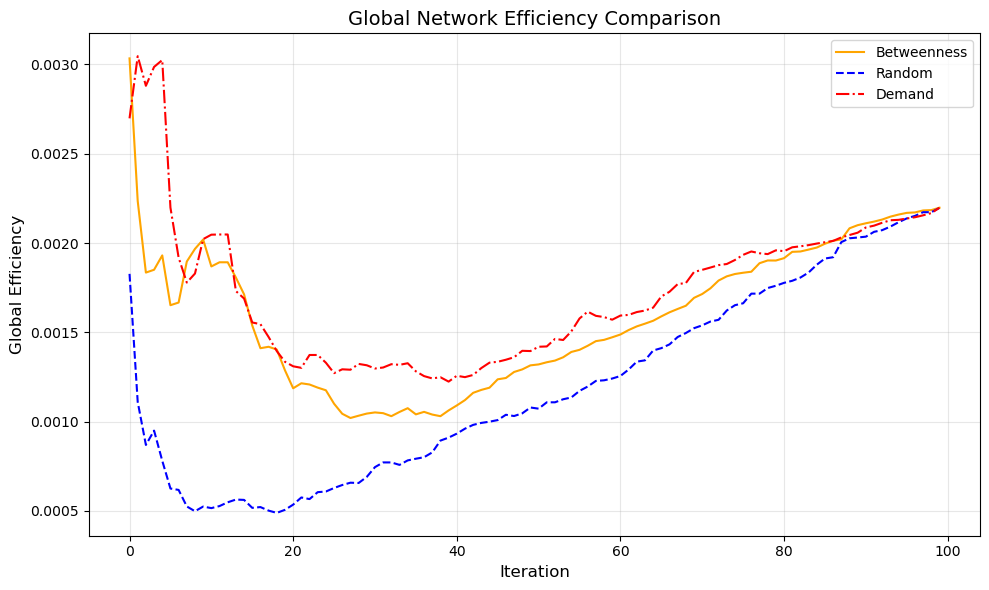

In [205]:
if os.path.exists(analysis_res_pickle):
    with open(analysis_res_pickle, 'rb') as f:
        analysis_results = pickle.load(f)
else:
    analysis_results = {}

if rerun or 'efficiency_demand' not in analysis_results:
    efficiency_metrics = {
        'efficiency': [
            calculate_global_efficiency(G, numnodepairs=1000, normalized=True, weight='length')
            for G in GT_abstracts
        ],
        'efficiency_random': [
            calculate_global_efficiency(G, numnodepairs=1000, normalized=True, weight='length')
            for G in GT_abstracts_random
        ],
        'efficiency_demand': [
            calculate_global_efficiency(G, numnodepairs=1000, normalized=True, weight='length')
            for G in GT_abstracts_demand
        ]
    }
    

    analysis_results.update(efficiency_metrics)  
    with open(analysis_res_pickle, 'wb') as f:
        pickle.dump(analysis_results, f)
    pd.DataFrame({k: pd.Series(v) for k, v in analysis_results.items()}).to_csv(analysis_res_csv, index=False)


plt.figure(figsize=(10, 6))

# Plot efficiency from analysis_results
plt.plot(
    analysis_results['efficiency'],
    linestyle='-', 
    color='orange',
    label='Betweenness'
)
plt.plot(
    analysis_results['efficiency_random'],
    linestyle='--', 
    color='blue',
    label='Random'
)
plt.plot(
    analysis_results['efficiency_demand'],
    linestyle='-.', 
    color='red',
    label='Demand'
)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Global Efficiency', fontsize=12)
plt.title('Global Network Efficiency Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

output_path = PATH["plots"] + "/" + placeid + "/global_eff.png"
plt.savefig(output_path, dpi=300)
plt.show()

In [206]:
# Create plot
plt.figure(figsize=(10, 6))

# Plot both lines
plt.plot(x, eff_GTs, label='GTs',  linestyle='-', color='blue')
plt.plot(x_random, eff_GTs_random, label='GTs Random', linestyle='--', color='red')

# Add labels and title
plt.xlabel('Graph Index', fontsize=12)
plt.ylabel('Global Efficiency', fontsize=12)
plt.title('Global Network Efficiency Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

NameError: name 'x' is not defined

<Figure size 1000x600 with 0 Axes>

### Local

Both

In [ ]:
# def calculate_efficiencies(G):
#     """Calculate both global and local efficiencies"""
#     # Convert to undirected graph
#     undirected_G = nx.Graph(G)
    
#     try:
#         global_eff = nx.global_efficiency(undirected_G)
#     except nx.NetworkXError:
#         global_eff = 0
        
#     try:
#         local_eff = nx.local_efficiency(undirected_G)
#     except nx.NetworkXError:
#         local_eff = 0
        
#     return global_eff, local_eff

# def plot_efficiency_comparison(GTs, GTs_random):
#     """Plot comparison of both efficiency metrics"""
#     # Calculate efficiencies
#     global_GTs, local_GTs = zip(*[calculate_efficiencies(G) for G in GTs])
#     global_random, local_random = zip(*[calculate_efficiencies(G) for G in GTs_random])
    
#     # Create plots
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
#     # Global efficiency plot
#     ax1.plot(global_GTs, 'b-', linewidth=2, label='GTs Global Eff')
#     ax1.plot(global_random, 'r--', linewidth=2, label='GTs_random Global Eff')
#     ax1.set_title('Global Network Efficiency Comparison')
#     ax1.set_ylabel('Efficiency')
#     ax1.legend()
#     ax1.grid(True)
#     ax1.set_ylim(0, 1)
    
#     # Local efficiency plot
#     ax2.plot(local_GTs, 'g-', linewidth=2, label='GTs Local Eff')
#     ax2.plot(local_random, 'm--', linewidth=2, label='GTs_random Local Eff')
#     ax2.set_title('Local Network Efficiency Comparison')
#     ax2.set_ylabel('Efficiency')
#     ax2.legend()
#     ax2.grid(True)
#     ax2.set_ylim(0, 1)
    
#     plt.tight_layout()
#     plt.show()

# # Usage example:
# plot_efficiency_comparison(GTs, GTs_random)

## PCT

In [ ]:
# read in pct lines

## Pretty plots of networks

In [ ]:
iteration_number = 99

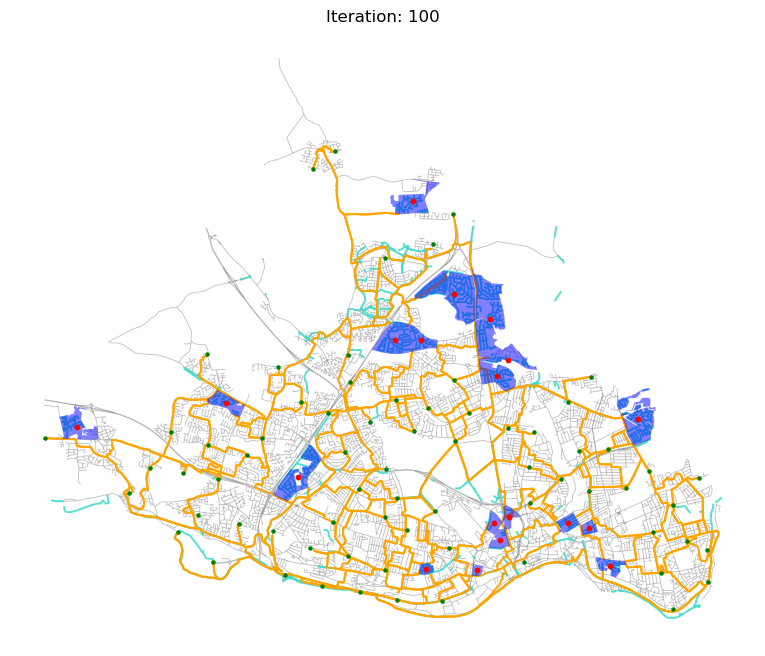

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height as needed



G_biketrackcarall_edges = ox.graph_to_gdfs(G_biketrackcarall, nodes=False)
G_biketrackcarall_edges = G_biketrackcarall_edges.to_crs(epsg=3857)  # Ensure CRS matches
G_biketrackcarall_edges.plot(ax=ax, color='grey', linewidth=0.6, alpha=0.5, zorder = 0)  # Light grey with thin linewidth

# Add bike track edges
#G_biketrack = {}
#G_biketrack[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrack')
#G_biketrack[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
#G_biketrack = copy.deepcopy(G_biketrack[placeid])
G_biketrack_edges = ox.graph_to_gdfs(G_biketrack, nodes=False)
G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)
G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=1.4, alpha=0.9, zorder = 1)  # Light grey with thin linewidth


# Plot the main graph and layers
GT_nodes, GT_edges = ox.graph_to_gdfs(GTs[iteration_number])
GT_edges = GT_edges.to_crs(epsg=3857)
GT_edges.plot(ax=ax, color='orange')
ltn_points.to_crs(epsg=3857).plot(ax=ax, color='red', markersize=10, zorder=4)
tess_points.to_crs(epsg=3857).plot(ax=ax, color='green', markersize=5, zorder = 3)


ltns = ltns.to_crs(epsg=3857)  # Ensure the CRS matches
ltns.plot(ax=ax, color='blue', alpha=0.5, label=f"Low Traffic Neighbourhoods", zorder=2)


# Remove x and y axis labels and ticks
ax.axis('off')  # This removes the entire axis, including labels and ticks

ax.set_title(f"Iteration: {iteration_number + 1}")
#ax.legend(loc="upper left")

output_path = fr"C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\Conferances etc\GISRUK 2025\Plots\{iteration_number}_network_plot.png"
plt.savefig(output_path, dpi=600, bbox_inches='tight'
            #, transparent=True
            )
# Show the plot
plt.show()


# GIFs

In [ ]:
# gif_path = r"C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth_external\videos\newcastle\investment_animation_pct.gif"

# # Set up a figure for animation
# fig, ax = plt.subplots(figsize=(12, 8))

# def update(idx):
#     """Update function for each frame in the animation."""
#     ax.clear()  # Clear previous frame
#     G = GTs[idx]
#     # Skip empty graphs
#     if len(G.edges()) == 0:
#         print(f"Graph {idx + 1} has no edges, skipping plot.")
#         return
    
#     # Add G_weighted edges
#     G_weighted_edges = ox.graph_to_gdfs(G_weighted, nodes=False)
#     G_weighted_edges = G_weighted_edges.to_crs(epsg=3857)
#     G_weighted_edges.plot(ax=ax, color='grey', linewidth=0.5, alpha=0.6, zorder=0)

#     # Add bike track edges
#     G_biketrack_nodes, G_biketrack_edges = ox.graph_to_gdfs(G_biketrack)
#     G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)
#     G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=0.5, alpha=0.8, zorder=1)

#     # Plot main graph
#     GT_nodes, GT_edges = ox.graph_to_gdfs(G)
#     GT_edges = GT_edges.to_crs(epsg=3857)
#     GT_edges.plot(ax=ax, color='orange')

#     # Plot additional layers
#     ltn_gdf.plot(ax=ax, color='red', markersize=10, zorder=4)
#     tess_gdf.plot(ax=ax, color='green', markersize=5, zorder=3)

#     # Plot the neighbourhood
#     placename = "Newcastle Upon Tyne"
#     if placename in neighbourhoods:
#         neighbourhood_gdf = neighbourhoods[placename].to_crs(epsg=3857)
#         neighbourhood_gdf.plot(ax=ax, color='blue', alpha=0.5, zorder=2)

#     # Remove axis and set title
#     ax.axis('off')
#     ax.set_title(f"Meters of investment: {D/10}")

# # Create animation
# ani = animation.FuncAnimation(fig, update, frames=len(GTs), repeat=False)

# # Save the animation as a GIF using PillowWriter
# ani.save(gif_path, writer=animation.PillowWriter(fps=6))

# print(f"GIF saved to: {gif_path}")

1 Cities loaded
1 Cities loaded
GIF saved to: ../../bikenwgrowth_external/videos/newcastle/betweenness_greedyTri.gif


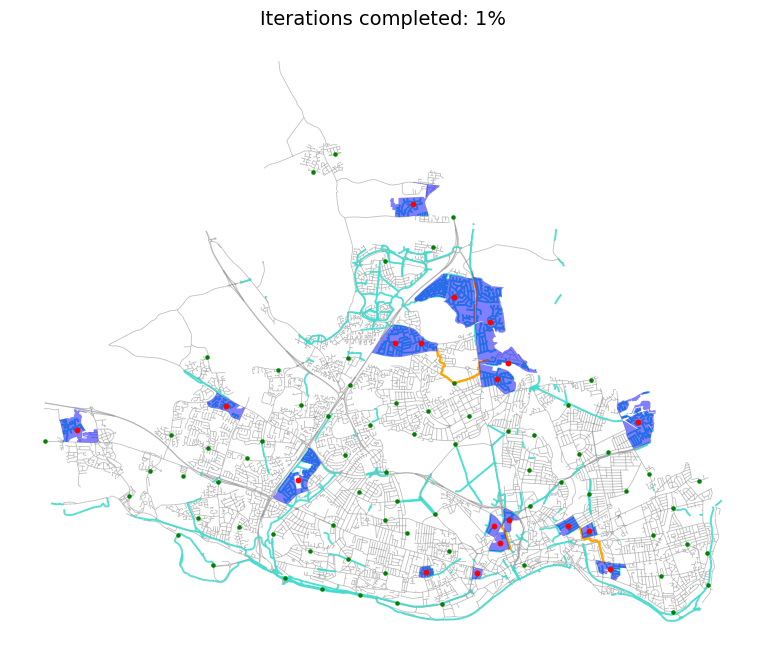

In [ ]:
# # delete once happy with cell below
# neighbourhoods = load_neighbourhoods(os.path.join(PATH["data"], placeid))
# G_biketrackcarall_edges = (
#     ox.graph_to_gdfs(G_biketrackcarall, nodes=False)
#       .to_crs(epsg=3857)
# )
# G_biketrack_edges = (
#     ox.graph_to_gdfs(G_biketrack, nodes=False)
#       .to_crs(epsg=3857)
# )

# ltn_points_crs = ltn_points.to_crs(epsg=3857)
# tess_points_crs = tess_points.to_crs(epsg=3857)
# neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
# ltns = neighbourhoods.get("ltns", None)
# ltns_gdf = None
# if neighbourhoods:
#     _, ltns_gdf = next(iter(neighbourhoods.items())) # get the first geodataframe in neighbourhoods. Should fix this to a more elegant solution
#     ltns = ltns_gdf.to_crs(epsg=3857) 


# fig, ax = plt.subplots(figsize=(12, 8))  

# def update(idx):
#     """Update function called for each animation frame."""
#     ax.clear()  # clear the axis for the new frame

#     # Plot the static background layers first.
#     G_biketrackcarall_edges.plot(ax=ax, color='grey', linewidth=0.6, alpha=0.5, zorder=0)
#     G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=1.4, alpha=0.9, zorder=1)

#     # Get the current main graph from your list of graphs GTs.
#     current_graph = GTs[idx]
#     if len(current_graph.edges()) == 0:
#         print(f"Graph {idx + 1} has no edges, skipping plot.")
#         return

#     # Convert the main graph to GeoDataFrames and reproject
#     GT_nodes, GT_edges = ox.graph_to_gdfs(current_graph)
#     GT_edges.to_crs(epsg=3857).plot(ax=ax, color='orange')
    
#     # Plot additional layers.
#     ltn_points_crs.plot(ax=ax, color='red', markersize=10, zorder=4)
#     tess_points_crs.plot(ax=ax, color='green', markersize=5, zorder=3)
#     ltns.plot(ax=ax, color='blue', alpha=0.5, zorder=2)

#     ax.axis('off')
#     ax.set_title(f"Iterations completed: {idx + 1}%", fontsize=14)


# ani = animation.FuncAnimation(fig, update, frames=len(GT_abstracts), repeat=False)

# # Construct the output file path flexibly
# output_gif = os.path.join(PATH["videos"], placeid + "/" f"investment_animation{prune_measure}.gif")
# output_gif = os.path.join(PATH["videos"], placeid + "/" f"betweenness_greedyTri.gif")
# # Create the directory if it doesn't exist.
# os.makedirs(os.path.dirname(output_gif), exist_ok=True)

# # Save the animation as a GIF with PillowWriter.
# ani.save(output_gif, writer=animation.PillowWriter(fps=6))

# print(f"GIF saved to: {output_gif}")

In [14]:
# new plotting function
def plot_investment_animation(
    graph_list,
    output_path,
    G_biketrackcarall,
    G_biketrack,
    ltn_points,
    tess_points,
    neighbourhoods,
    fps=4,
    title_prefix="Iteration number: ",
    crs_epsg=3857,
    figsize=(12, 8)
):
    """Generate and save an animated GIF showing network growth over time."""

    G_biketrackcarall_edges = (
        ox.graph_to_gdfs(G_biketrackcarall, nodes=False).to_crs(epsg=crs_epsg)
    )
    G_biketrack_edges = (
        ox.graph_to_gdfs(G_biketrack, nodes=False).to_crs(epsg=crs_epsg)
    )
    ltn_points_crs = ltn_points.to_crs(epsg=crs_epsg)
    tess_points_crs = tess_points.to_crs(epsg=crs_epsg)

    # Get a neighbourhood GeoDataFrame from the dictionary
    ltns = None
    if neighbourhoods:
        _, ltns_gdf = next(iter(neighbourhoods.items()))
        ltns = ltns_gdf.to_crs(epsg=crs_epsg)

    # Set up the figure
    fig, ax = plt.subplots(figsize=figsize)

    def update(idx):
        ax.clear()
        G = graph_list[idx]
        if 'crs' not in G.graph:
            G.graph['crs'] = f"epsg:{crs_epsg}"

        # Static background layers
        G_biketrackcarall_edges.plot(ax=ax, color='grey', linewidth=0.6, alpha=0.5, zorder=0)
        G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=1.4, alpha=0.9, zorder=1)

        # Skip empty graphs
        if len(G.edges()) == 0:
            print(f"Graph {idx + 1} has no edges, skipping.")
            return

        # Main graph
        _, edges = ox.graph_to_gdfs(G)
        edges.to_crs(epsg=crs_epsg).plot(ax=ax, color='orange')

        # Point layers
        ltn_points_crs.plot(ax=ax, color='red', markersize=10, zorder=4)
        tess_points_crs.plot(ax=ax, color='green', markersize=5, zorder=3)

        # LTN areas
        if ltns is not None:
            ltns.plot(ax=ax, color='blue', alpha=0.5, zorder=2)

        ax.axis('off')
        ax.set_title(f"{title_prefix} - iterations completed: {idx + 1}%", fontsize=14)

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(graph_list), repeat=False)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)


    ani.save(output_path, writer=animation.PillowWriter(fps=fps), dpi=400)
    print(f"GIF saved to: {output_path}")

1 Cities loaded
GIF saved to: ../../bikenwgrowth_external/videos/newcastle\demand_abstract_animation.gif


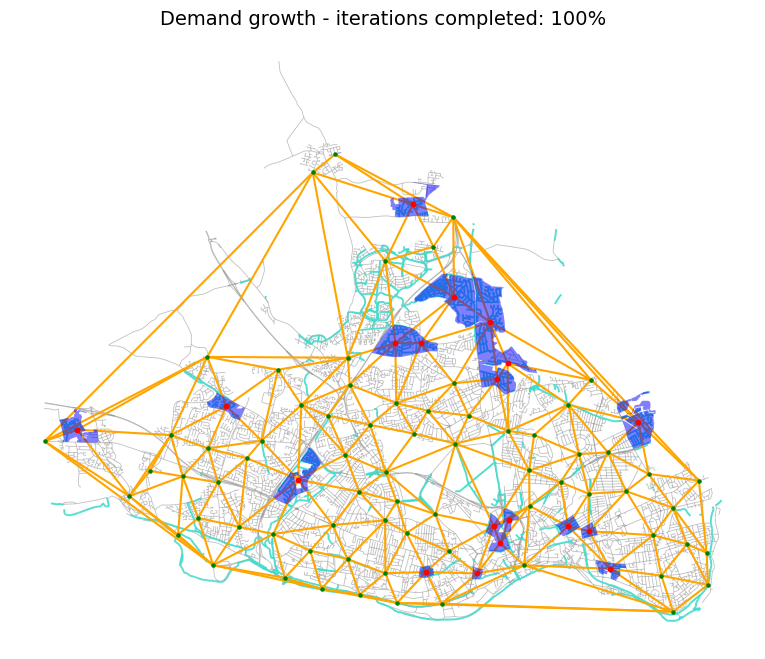

In [ ]:
# run plotting function
plot_investment_animation(
    graph_list=GT_abstracts_demand,
    output_path=os.path.join(PATH["videos"], placeid, f"demand_abstract_animation.gif"),
    G_biketrackcarall=G_biketrackcarall,
    G_biketrack=G_biketrack,
    ltn_points=ltn_points,
    tess_points=tess_points,
    neighbourhoods=load_neighbourhoods(os.path.join(PATH["data"], placeid)),
    title_prefix="Demand growth"
)

## Unfinshed

In [ ]:
metrics_GTs, metrics_GTs_random = compare_against_existing(GTs, GTs_random, G_biketrack_no_ltn) # no differance?
plot_comparison(metrics_GTs, metrics_GTs_random)

In [ ]:
Audio(sound_file, autoplay=True) 